# Simulated Based Inference of  BOLD by Generic Hopf model 

### Set up

In [1]:
import os
import sys
import time
import errno
import time
import timeit


import numpy as np
from numba import jit
import scipy as scp
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import torch
import sbi 

import sbi.inference
from sbi.inference.base import infer


from sbi.inference import SNPE, SNLE, SNRE, prepare_for_sbi ,simulate_for_sbi
from sbi.inference import likelihood_estimator_based_potential, DirectPosterior, MCMCPosterior, VIPosterior

from sbi.analysis import pairplot
import sbi.utils as utils

In [3]:
from typing import Any, Callable, Dict, List, Optional, Tuple, Union, cast

In [4]:
from FCD import extract_FCD

In [5]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors, cm
import matplotlib.colors as mcolors
from IPython.display import HTML

In [6]:
import warnings
warnings.simplefilter("ignore")

In [7]:
%pylab inline
#%matplotlib notebook

Populating the interactive namespace from numpy and matplotlib


In [8]:
print('Running on numpy: v{}'.format(np.version.version))
print('Running on torch: v{}'.format(torch.__version__))
print('Running on sbi: v{}'.format(sbi.__version__))

Running on numpy: v1.21.5
Running on torch: v1.10.2+cu102
Running on sbi: v0.18.0


In [9]:
sns.set(style="white")
plt.style.use('seaborn-talk');
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'

In [10]:
cwd = os.getcwd()
cwd

'/data/SBI/GenericHopf_SBI_GenericSC'

In [11]:
import warnings
np.seterr(all = 'ignore')
warnings.filterwarnings("ignore")

In [12]:
Res_dir='Res_SBI_BNM_GenericHopf_TrueSCavgn_InferG_MomentsFCFCD_savesim1k_v18'

# Load the Human Connectome

In [13]:
weights = np.load('connectomes/hcp-100.npz')['weights']
weights += weights.transpose((0, 2, 1))
#weights = np.log(1 + weights)
weights.shape

(100, 84, 84)

In [14]:
#weights=weights[int(100*np.random.rand(1)),:,:]
weights_avg=np.mean(weights, axis=0)

In [15]:
weights_avg.shape, weights_avg.min(), weights_avg.max()

((84, 84), 0.0, 8823.68)

In [16]:
nn=weights_avg.shape[0]
print  ('The number of regions  is: ', nn)

The number of regions  is:  84


In [17]:
SC_avg_n = weights_avg/np.max(weights_avg)

In [18]:
SC_avg_n.shape, SC_avg_n.min(), SC_avg_n.max()

((84, 84), 0.0, 1.0)

In [19]:
np.save(os.path.join(Res_dir, 'SC_true_avg_n.npy') , SC_avg_n)

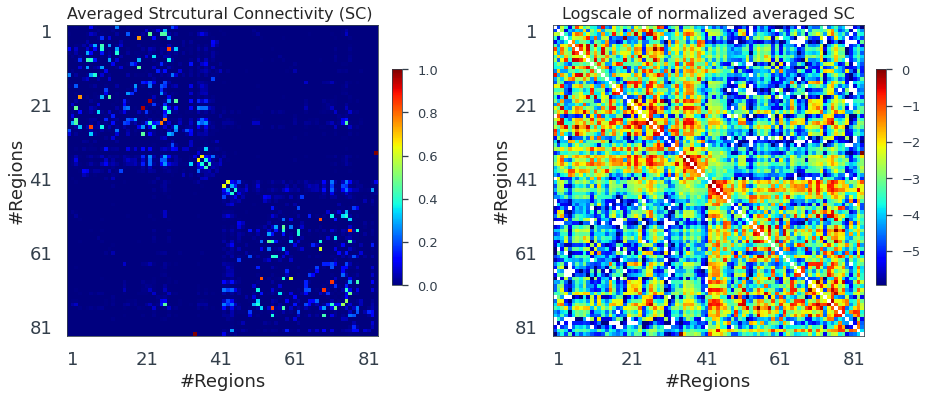

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
norm = colors.LogNorm(1e-7, SC_avg_n.max())
i=axs[0].imshow(SC_avg_n,cmap=cm.jet)
colorbar_ax = fig.add_axes([0.45, 0.3, 0.01, 0.5])
fig.colorbar(i, cax=colorbar_ax)
axs[0].set_title('Averaged Strcutural Connectivity (SC) ', fontsize=16.0)
axs[0].set_ylabel('#Regions', fontsize=18.0)
axs[0].set_xlabel('#Regions', fontsize=18.0)
axs[0].tick_params(labelsize=18)
axs[0].xaxis.set_ticks(np.r_[1:nn+1][::20])
axs[0].yaxis.set_ticks(np.r_[1:nn+1][::20])

i=axs[1].imshow(np.log10(SC_avg_n),cmap=cm.jet)
colorbar_ax = fig.add_axes([.93, 0.3, 0.01, 0.5])
fig.colorbar(i, cax=colorbar_ax)
axs[1].set_title('Logscale of normalized averaged SC', fontsize=16.0)
axs[1].set_ylabel('#Regions', fontsize=18.0)
axs[1].set_xlabel('#Regions', fontsize=18.0)
axs[1].tick_params(labelsize=18)
axs[1].xaxis.set_ticks(np.r_[1:nn+1][::20])
axs[1].yaxis.set_ticks(np.r_[1:nn+1][::20])

fig.tight_layout(pad=2)

plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SCmatrix_avg_Normalized.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SCmatrix_avg_Normalized.eps"), doi=800)
plt.show()

### constants

In [21]:
eta_c=0       
delta_eta=.5                  
prior_std =1.0
sd_thr=0.5

# whole-brain network simulation

$  \frac{d x_i}{dt}= (\eta_i-x_i^2-y_i^2)x_i -\omega_i y_i+ G \sum_{j=1}^{N} C_{j,i} ( x_j- x_i) +\sigma \xi_i(t)$

$ \frac{d y_i}{dt}= (\eta_i-x_i^2-y_i^2)y_i +\omega_i x_i + G \sum_{j=1}^{N} C_{j,i} ( y_j- y_i)+ \sigma \xi_i(t)$


In [22]:
from GenericHopfModel import GenericHopfBOLD

In [23]:
from GenericHopfModel_features import calculate_summary_statistics

In [24]:
@jit(nopython=False)
def GenericHopf_simulator_wrapper(params):
    
    params = np.asarray(params)
    
    ## fixed values: simulation time lenght (T), the time step (dt), the array of time points (ts),  
    ##  noise level (sigma), time step for BalloonWindkessel, downsampling (ds). 
    
    Tmax = 120.0
    dt=0.001
    ts = np.arange(0, Tmax + dt, dt)
    sigma=1e-1
    dt_bold=0.001
    ds=180


    ## initial conditions
    x_init=0
    y_init=0
    init_conditions = np.array([x_init, y_init])

    ##param : global coupling parameter (G)
    params_G=params[0]
    
    nn=SC_avg_n.shape[0]
    
    Simulated_BOLD = GenericHopfBOLD(eta_true, omega_true, init_conditions, sigma, params_G, SC_avg_n,  dt, dt_bold, Tmax, ds)

    #summstats = torch.as_tensor(calculate_summary_statistics(BOLD_simulated, nn, features=['FC_corr', 'FCD_corr']))

    return Simulated_BOLD 

### some simulations for  sanity check


In [25]:
Tmax = 120.0
dt=0.001
ts = np.arange(0, Tmax + dt, dt)
sigma=1e-1
dt_bold=0.001
ds=180

In [26]:
nt=ts.shape[0]
nt_bold=int(nt/ds)
nt, nt_bold

(120001, 666)

In [27]:
nn=SC_avg_n.shape[0]
nn

84

In [28]:
## Constant values: the intrinsic frequency generated randomly between [0.02-0.04] HZ 
freq_true = np.random.uniform(0.02, 0.04,nn)
omega_true=2*np.pi*freq_true
omega_true.shape

(84,)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


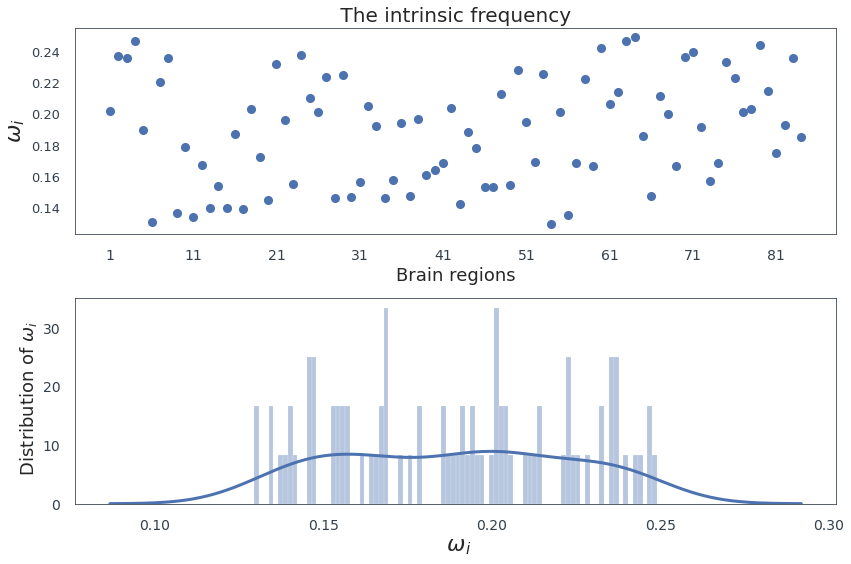

In [29]:
plt.figure(figsize=(12, 8))

plt.subplot(211)
plt.plot(omega_true, 'bo')
plt.title(' The intrinsic frequency ',fontsize=20)
plt.xlabel('Brain regions',fontsize=18)
plt.ylabel('$\omega_i$',fontsize=22)
plt.xticks(np.r_[0:nn][::10], np.r_[1:nn+1][::10], fontsize=14)

plt.subplot(212)
prior_plot=sns.distplot(omega_true, bins=84,hist=True, kde=True, color="b", kde_kws=dict(linewidth=3))
plt.ylabel(' Distribution of $\omega_i$',fontsize=18)
plt.xlabel(' $\omega_i$',fontsize=22)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Omega_true.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Omega_true.eps"), doi=800)
plt.show()

In [30]:
eta_mu_true=-1.
eta_std_true=1.
eta_heter_rnd=np.random.randn(nn) 

In [31]:
eta_true=eta_mu_true+eta_std_true * eta_heter_rnd
eta_true.shape 

(84,)

In [32]:
## for the case of bi-modality
# eta_ws_true = pm.floatX([0.8, 0.2])
# eta_mu_true = pm.floatX([-3.0, -1.0])
# eta_std_true = pm.floatX([0.1, 0.1])
#components=np.random.choice(eta_mu_true.size, size=nn, p=eta_ws_true)
#eta_true=np.random.normal(mu[components], std[components], size=nn)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


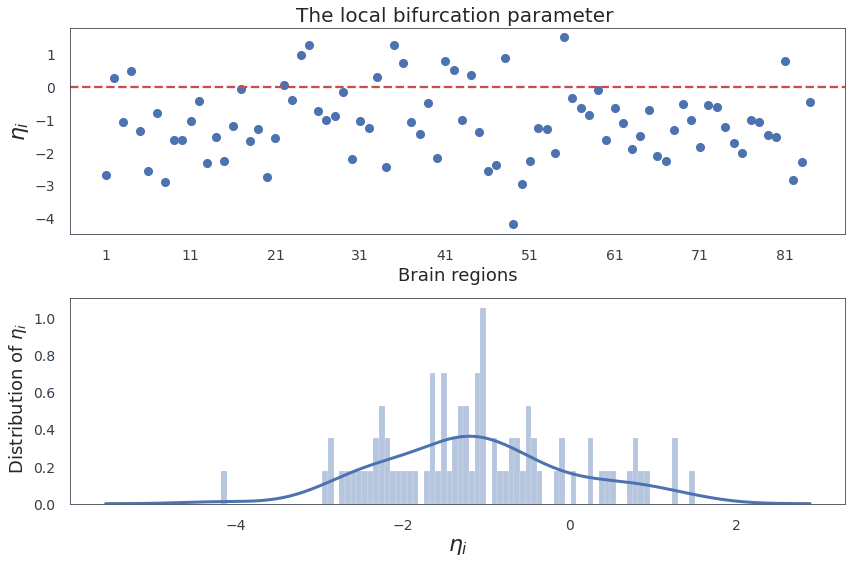

In [33]:
plt.figure(figsize=(12, 8))

plt.subplot(211)

plt.plot(eta_true, 'bo')
plt.axhline(y=0.0, color='r', linestyle='--')
plt.title('The local bifurcation parameter ',fontsize=20)
plt.xlabel('Brain regions',fontsize=18)
plt.ylabel('$\eta_i$',fontsize=22)
plt.xticks(np.r_[0:nn][::10], np.r_[1:nn+1][::10], fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(212)
#plt.hist(eta_true, bins=84);
prior_plot=sns.distplot(eta_true, bins=84, hist=True, kde=True, color="b", kde_kws=dict(linewidth=3))
plt.ylabel(' Distribution of $\eta_i$',fontsize=18)
plt.xlabel('$\eta_i$',fontsize=22)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Eta_true.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Eta_true.eps"), doi=800)
plt.show()

In [34]:
## initial conditions
x_init=0
y_init=0
init_conditions = np.array([x_init, y_init])

In [35]:
G_true=0.2

In [36]:
# stacking all the params
params_true = np.hstack([G_true])
params_true.shape

(1,)

In [37]:
params_true

array([0.2])

In [38]:
np.save(os.path.join(Res_dir, 'eta_true.npy') , eta_true)
np.save(os.path.join(Res_dir, 'omega_true.npy') , omega_true)
np.save(os.path.join(Res_dir, 'params_true.npy') , params_true)

### Run Sanity check with JIT

In [39]:
start_time = time.time()

BOLD_ =GenericHopfBOLD(eta_true, omega_true, init_conditions, sigma, G_true, SC_avg_n,  dt, dt_bold, Tmax, ds)

print(" one simulation (sec) takes:" , (time.time() - start_time))

 one simulation (sec) takes: 5.900289297103882


In [40]:
start_time = time.time()

BOLD_ =GenericHopfBOLD(eta_true, omega_true, init_conditions, sigma, G_true, SC_avg_n,  dt, dt_bold, Tmax, ds)

print(" one JIT simulation  (sec) takes:" , (time.time() - start_time))

 one JIT simulation  (sec) takes: 3.770904779434204


In [41]:
BOLD_.shape

(56028,)

In [42]:
BOLD_sanity=BOLD_.reshape(nn, int(BOLD_.shape[0]/nn))

BOLD_sanity.shape

(84, 667)

In [43]:
np.save(os.path.join(Res_dir, 'Sim_BOLD_TrueSCavgn_GenericHopf_G_'+str(G_true)+'.npy') , BOLD_sanity)

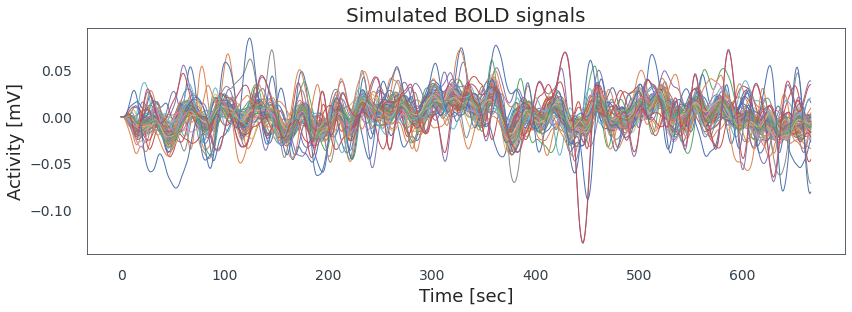

In [44]:
plt.figure(figsize=(12,4.5))
plt.plot(BOLD_sanity.T, lw=1)
plt.title("Simulated BOLD signals",fontsize=20)
plt.xlabel('Time [sec]',fontsize=18)
plt.ylabel('Activity [mV]',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_sanity.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_sanity.eps"), doi=800)
plt.show()

In [45]:
FCcorr=np.corrcoef(BOLD_sanity)
FCcorr.shape

(84, 84)

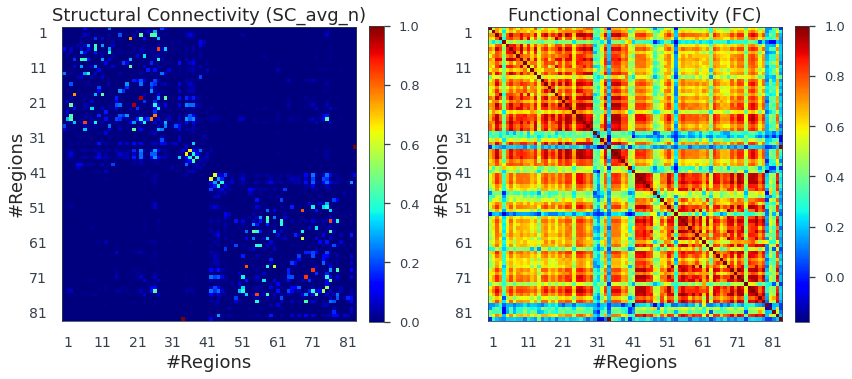

In [46]:
plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.imshow((SC_avg_n), interpolation='nearest', cmap='jet' )
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Structural Connectivity (SC_avg_n)', fontsize=18)
plt.ylabel('#Regions', fontsize=18.0)
plt.xlabel('#Regions', fontsize=18.0)
plt.xticks(np.r_[1:nn+1][::10], fontsize=14)
plt.yticks(np.r_[1:nn+1][::10], fontsize=14)

plt.subplot(122)
im = plt.imshow(FCcorr,cmap=cm.jet)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.gca().set_title('Functional Connectivity (FC)', fontsize=18.0)
plt.ylabel('#Regions', fontsize=18.0)
plt.xlabel('#Regions', fontsize=18.0)
plt.xticks(np.r_[1:nn+1][::10], fontsize=14)
plt.yticks(np.r_[1:nn+1][::10], fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_sanity_SCFC.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_sanity_SCFC.eps"), doi=800)
plt.show()

In [47]:
wwidth=30
maxNwindows=200
olap=0.94

In [48]:
FCDcorr,Pcorr,shift=extract_FCD(BOLD_sanity,wwidth,maxNwindows,olap,mode='corr')
FCDcorr.shape

(207, 207)

In [49]:
FCDcorr.var(), FCDcorr.sum(), 

(0.027834416183038852, 15882.569051643868)

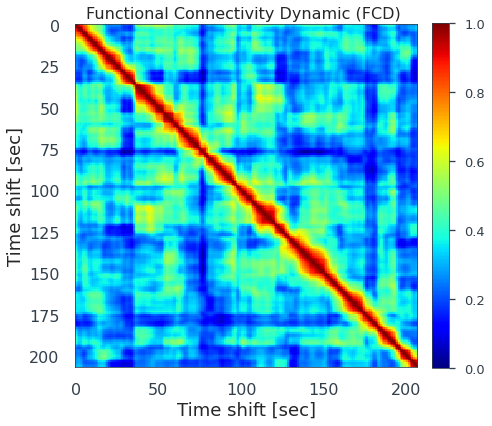

In [50]:
plt.figure(figsize=(7, 7))
plt.imshow(FCDcorr, vmin=0,vmax=1, interpolation='nearest', cmap='jet' )
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Functional Connectivity Dynamic (FCD) ', fontsize=16)
plt.ylabel('Time shift [sec]', fontsize=18.0)
plt.xlabel('Time shift [sec]', fontsize=18.0)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_sanity_FCD.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_sanity_FCD.eps"), doi=800)
plt.show()

In [51]:
_=calculate_summary_statistics(BOLD_, nn, features=['moments','FC_corr', 'FCD_corr'])
print('feature shape:', _.shape)

feature shape: (498,)


### 2. Prior over model parameters

Here we provide a plausible ranges for the parameters that we aim to infer, by placing a uniform prior on them.

In [52]:
prior_min_G=0.0*np.ones(1)

prior_max_G=1.0*np.ones(1)

In [53]:
prior_min=np.hstack([prior_min_G])
prior_max=np.hstack([prior_max_G])

In [54]:
prior_min.shape, prior_max.shape

((1,), (1,))

In [55]:
prior = utils.torchutils.BoxUniform(low=torch.as_tensor(prior_min), high=torch.as_tensor(prior_max))

In [56]:
num_params=len(prior_min)
print('numumber of params :', num_params)

numumber of params : 1


### Save simulations

In [57]:
num_sim=1000

In [58]:
try:
    os.mkdir(Res_dir+'/output_simulations')
except OSError as exc:
    if exc.errno != errno.EEXIST:
        raise
    pass

In [59]:
mysavepath = os.path.join(Res_dir, 'output_simulations/simulated_theta_x_GenericHopf.npz')
mysavepath

'Res_SBI_BNM_GenericHopf_TrueSCavgn_InferG_MomentsFCFCD_savesim1k_v18/output_simulations/simulated_theta_x_GenericHopf.npz'

In [60]:
def Save_simulations(simulator: Callable, prior, mysavepath, num_simulations: int):

    simulator, prior = prepare_for_sbi(simulator, prior)
    
    theta, x = simulate_for_sbi(simulator=simulator,
                                proposal=prior,
                                num_simulations=num_simulations,
                                show_progress_bar=True,)

    print( 'theta shape:',theta.shape,flush=True)
    print('data shape:', x.shape,flush=True)

    np.savez(mysavepath,theta=theta,x=x)

In [61]:
start_time = time.time()

Save_simulations(GenericHopf_simulator_wrapper, prior, mysavepath, num_simulations=1)

print ("-"*60)
print("--- one simulation took: %s seconds ---" % (time.time() - start_time))

theta shape: torch.Size([1, 1])
data shape: torch.Size([1, 56028])
------------------------------------------------------------
--- one simulation took: 9.252967357635498 seconds ---


In [62]:
start_time = time.time()

Save_simulations(GenericHopf_simulator_wrapper, prior, mysavepath, num_simulations=1)

print ("-"*60)
print("--- one simulation with JIT took: %s seconds ---" % (time.time() - start_time))

theta shape: torch.Size([1, 1])
data shape: torch.Size([1, 56028])
------------------------------------------------------------
--- one simulation with JIT took: 7.716988563537598 seconds ---


In [63]:
start_time = time.time()

Save_simulations(GenericHopf_simulator_wrapper, prior, mysavepath, num_simulations=num_sim)

print ("-"*60)
print("---all simulations took:  %s seconds ---" % (time.time() - start_time))

Running 1000 simulations.:   0%|          | 0/1000 [00:00<?, ?it/s]

theta shape: torch.Size([1000, 1])
data shape: torch.Size([1000, 56028])
------------------------------------------------------------
---all simulations took:  3699.3597915172577 seconds ---


### Load simulations and calculate features

In [64]:
loaded_simulations=np.load(mysavepath)

In [65]:
theta_sim=loaded_simulations['theta']
x_sim=loaded_simulations['x']

In [66]:
print( 'theta shape:',theta_sim.shape,flush=True)
print('data shape:', x_sim.shape,flush=True)

theta shape: (1000, 1)
data shape: (1000, 56028)


In [67]:
if np.isfinite(np.sum(x_sim[0,:]))==True:
    _=calculate_summary_statistics(x_sim[0,:], nn, features=['moments', 'FC_corr', 'FCD_corr'])
    _.shape

num_features=_.shape[0]
print('feature shape:', num_features)

feature shape: 498


In [68]:
theta_features=np.zeros((num_sim,num_params))
x_features=np.zeros((num_sim,num_features))

In [69]:
print( 'theta shape:',theta_features.shape,flush=True)
print('data frature shape:', x_features.shape,flush=True)

theta shape: (1000, 1)
data frature shape: (1000, 498)


In [70]:
start_time = time.time()

i = 0
while i < 2*num_sim:
       if np.isfinite(np.sum(x_sim))==True:
              theta_features[i,:]=theta_sim[i,:] 
              x_features[i,:]=calculate_summary_statistics(x_sim[i,:], nn, features=['moments', 'FC_corr', 'FCD_corr'])
       if i == num_sim-1:
           break
       i += 1
    
print ("-"*60)
print("--- Calculating features took: %s seconds ---" % (time.time() - start_time))    

------------------------------------------------------------
--- Calculating features took: 228.8062720298767 seconds ---


In [71]:
np.isnan(np.sum(x_features))

False

In [72]:
x = np.array(x_features, dtype='float32')
x = torch.as_tensor(x)

theta = np.array(theta_features, dtype='float32')
theta = theta.reshape(theta.shape[0],num_params)
theta = torch.as_tensor(theta)

In [73]:
print( 'theta shape:',theta.shape,flush=True)
print('data feature shape:', x.shape,flush=True)

theta shape: torch.Size([1000, 1])
data feature shape: torch.Size([1000, 498])


### 3. Inference

Finally we use Sequential Neural Posterior Estimation (SNPE) to sample from the posterior $p(\theta|x)$. The inputs are prior, parameter theta and (the data features of) observation x, and it returns us the posterior $p(\theta|x)$.

In [74]:
inference = SNPE(prior, density_estimator='maf', device='cpu')

In [75]:
start_time = time.time()

posterior_estimator = inference.append_simulations(theta, x).train()

print ("-"*60)
print("---training took:  %s seconds ---" % (time.time() - start_time))

 Neural network successfully converged after 26 epochs.------------------------------------------------------------
---training took:  4.890951156616211 seconds ---


In [76]:
## Without the saving and loading simulations, we can run sbi using the default function "infer", as follows:
##posterior = infer(GenericHopf_simulator_wrapper, prior, method='SNPE',  num_simulations=10000, num_workers=1)

### Observed data set I (optimal G)

After the training NN, the posterior is amortized (i.e., no need to again train the neural network) and by providing the features of observation (empirical or simulated with same dimension as we used for training), we are able to efficiently obtain the posterior of parameters.

In the following we use different ground-truth values for simulation to validate the inference.

In [77]:
G_true=0.25

In [78]:
start_time = time.time()

BOLD_obs_ =GenericHopfBOLD(eta_true, omega_true, init_conditions, sigma, G_true, SC_avg_n,  dt, dt_bold, Tmax, ds)

print(" single sim (sec) takes:" , (time.time() - start_time))

 single sim (sec) takes: 6.703596830368042


In [79]:
obs_bold_features=calculate_summary_statistics(BOLD_obs_, nn, features=['moments', 'FC_corr', 'FCD_corr'])

In [80]:
obs_bold_features.max()

15448.880687397424

In [81]:
BOLD_obs_.shape, obs_bold_features.shape

((56028,), (498,))

In [82]:
BOLD_obs=BOLD_obs_.reshape(nn, int(BOLD_obs_.shape[0]/nn))
BOLD_obs.shape

(84, 667)

In [83]:
np.save(os.path.join(Res_dir, 'Sim_BOLDobserved_TrueSCavgn_GenericHopf_G_'+str(G_true)+'.npy') , BOLD_obs)

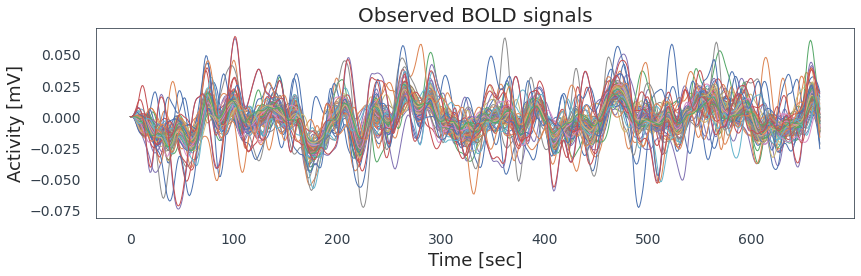

In [84]:
plt.figure(figsize=(12,4))
plt.plot(BOLD_obs.T, lw=1)
plt.title("Observed BOLD signals",fontsize=20)
plt.xlabel('Time [sec]',fontsize=18)
plt.ylabel('Activity [mV]',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_obs1.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_obs1.eps"), doi=800)
plt.show()

In [85]:
FCcorr_obs=np.corrcoef(BOLD_obs)
FCcorr_obs.shape

(84, 84)

In [86]:
FCDcorr_obs,Pcorr_obs,shift_obs=extract_FCD(BOLD_obs,wwidth,maxNwindows,olap,mode='corr')

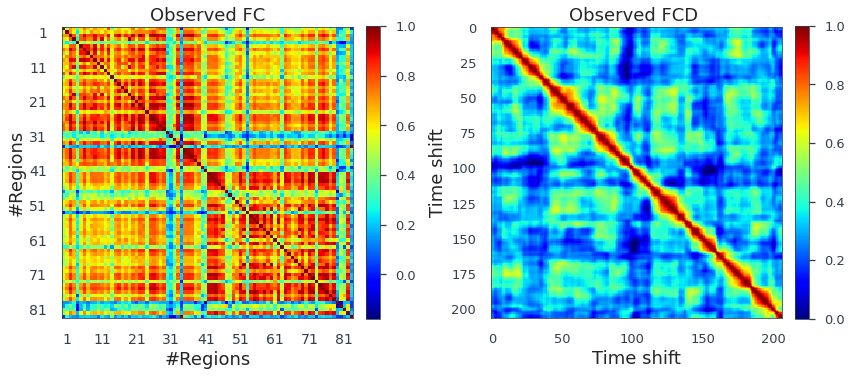

In [87]:
plt.figure(figsize=(12, 6))

plt.subplot(121)
im = plt.imshow(FCcorr,cmap=cm.jet)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.gca().set_title('Observed FC', fontsize=18.0)
plt.xticks(np.r_[1:nn+1][::10], fontsize=14)
plt.yticks(np.r_[1:nn+1][::10], fontsize=14)
plt.ylabel('#Regions', fontsize=18.0)
plt.xlabel('#Regions', fontsize=18.0)

plt.subplot(122)
plt.imshow(FCDcorr_obs, vmin=0,vmax=1, interpolation='nearest', cmap='jet' )
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Observed FCD ', fontsize=18)
plt.ylabel('Time shift', fontsize=18.0)
plt.xlabel('Time shift', fontsize=18.0)

plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_sanity_FC_FCD_obs1.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_sanity_FC_FCD_obs1.eps"), doi=800)
plt.show()

### Posterior of G for  data set I

In [88]:
labels_params = [r'$G$']

In [89]:
num_samples=2000

In [90]:
posterior = DirectPosterior(posterior_estimator, prior,) 

In [91]:
start_time = time.time()

posterior_samples = posterior.sample((num_samples,), obs_bold_features).numpy()

print(" Sampling posterior (sec) took:" , (time.time() - start_time))

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

 Sampling posterior (sec) took: 0.263824462890625


In [92]:
np.save(os.path.join(Res_dir, 'posterior_samples_obs1.npy') , posterior_samples)

In [93]:
posterior_samples.shape, params_true.shape

((2000, 1), (1,))

In [94]:
G_posterior=posterior_samples[:,0]
np.percentile(posterior_samples, [5, 95], axis=0)

array([[0.22104298],
       [0.2496943 ]])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


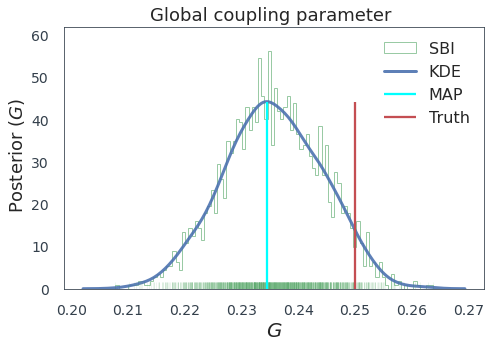

In [95]:
plt.figure(figsize=(7, 5))

#sns.distplot(G_posterior, bins=100, hist=True, kde=True, rug=True, color="b", kde_kws=dict(linewidth=3), label='SBI')
ax=sns.distplot(G_posterior, bins=100, hist=True, kde=True, rug=True, rug_kws={"alpha": 0.1, "color": "g"},
                  kde_kws={"color": "b", "alpha": 0.9, "lw": 3, "label": "KDE"},
                  hist_kws={"histtype": "step", "linewidth": 1, "alpha": 0.6, "color": "g"},
                  label='SBI')


x_ = ax.lines[0].get_xdata()
y_ = ax.lines[0].get_ydata()
ymax = max(y_)
xpos = np.argmax(y_, axis=0)
xmax = x_[xpos]
plt.vlines(x=xmax, ymin=0., ymax=y_.max(), colors='cyan', label='MAP')
plt.vlines(x=G_true, ymin=0., ymax=y_.max(), colors='r', label='Truth')

plt.title('Global coupling parameter ',fontsize=18)
plt.ylabel(' Posterior ' +r'${(G)}$', fontsize=18);  
plt.xlabel(r'${G}$', fontsize=20); 
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16, frameon=False)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_obs1.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_obs1.eps"), doi=800)
plt.show()

In [96]:
G_posterior.mean(), G_true

(0.23557928, 0.25)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


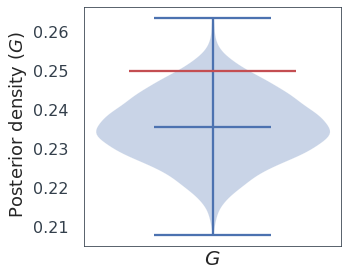

In [97]:
plt.figure(figsize=(5,4))
parts= plt.violinplot(G_posterior, widths=0.7, showmeans=True, showextrema=True);
plt.hlines(y=G_true, xmin=0.75, xmax=1.25, colors='r', label='Ground-truth')
#plt.plot(1,params_true[-1] ,'o', color='k', alpha=0.9, markersize=8)
plt.ylabel(' Posterior density ' +r'${(G)}$', fontsize=18);  
plt.xlabel(r'${G}$', fontsize=20); 
plt.xticks([])
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_InferredCoupling_obs1.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_InferredCoupling_obs1.eps"), doi=800)
plt.show()

In [98]:
np.percentile(posterior_samples, [5, 95], axis=0)

array([[0.22104298],
       [0.2496943 ]])

In [99]:
#np.percentile(posterior_sample, [50], axis=0)
BOLD_fit_ =GenericHopfBOLD(eta_true, omega_true, init_conditions, sigma, G_posterior.mean(), SC_avg_n,  dt, dt_bold, Tmax, ds)

In [100]:
BOLD_fit=BOLD_fit_.reshape(nn, int(BOLD_fit_.shape[0]/nn))

In [101]:
np.save(os.path.join(Res_dir, 'BOLD_obs1.npy') , BOLD_obs)
np.save(os.path.join(Res_dir, 'BOLD_fit1.npy') , BOLD_fit)

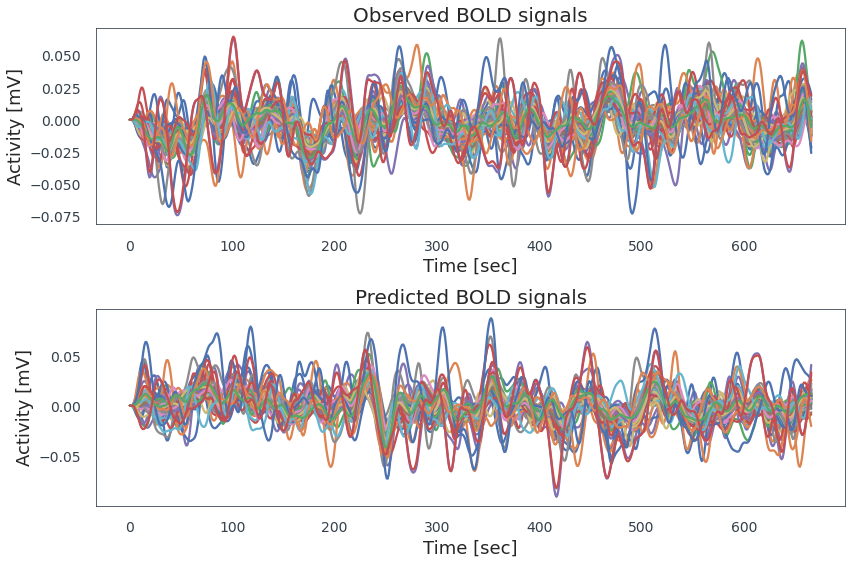

In [102]:
plt.figure(figsize=(12, 8))
plt.subplot(211);
plt.plot(BOLD_obs.T)
plt.title("Observed BOLD signals",fontsize=20)
plt.xlabel('Time [sec]',fontsize=18)
plt.ylabel('Activity [mV]',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(212)
plt.plot(BOLD_fit.T)
plt.title("Predicted BOLD signals",fontsize=20)
plt.xlabel('Time [sec]',fontsize=18)
plt.ylabel('Activity [mV]',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_FittedandobsTimeseries_obs1.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_FittedandobsTimeseries_obs1.eps"), doi=800)
plt.show()

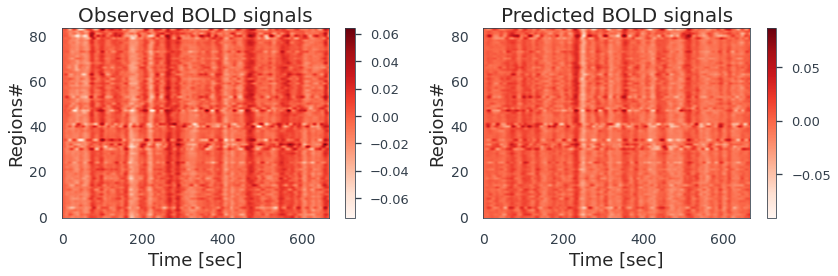

In [103]:
plt.figure(figsize=(12, 4))
plt.subplot(121);
plt.imshow(BOLD_obs, aspect='auto', interpolation='bilinear',  origin='lower', cmap='Reds')
plt.colorbar();
plt.title("Observed BOLD signals",fontsize=20)
plt.xlabel('Time [sec]',fontsize=18)
plt.ylabel("Regions#", fontsize=18);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(122)
plt.imshow(BOLD_fit, aspect='auto', interpolation='bilinear',  origin='lower', cmap='Reds')
plt.colorbar();
plt.title("Predicted BOLD signals",fontsize=20)
plt.xlabel('Time [sec]',fontsize=18)
plt.ylabel("Regions#", fontsize=18);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_FittedandobsImshow_obs1.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_FittedandobsImshow_obs1.eps"), doi=800)
plt.show()

In [104]:
FCcorr_obs=np.corrcoef(BOLD_obs)
FCcorr_fit=np.corrcoef(BOLD_fit)

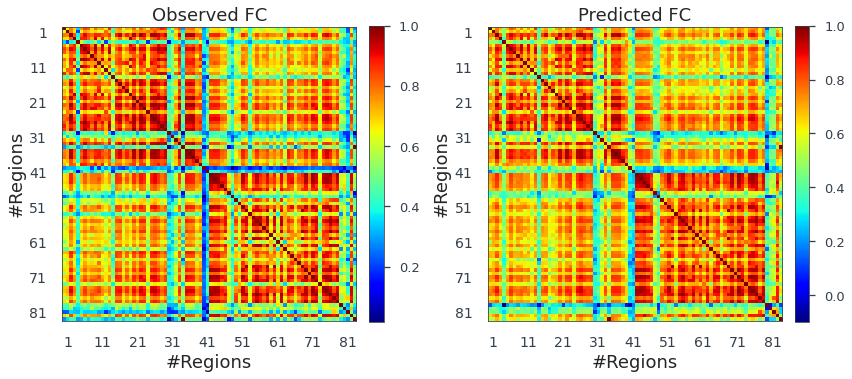

In [105]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow((FCcorr_obs), interpolation='nearest', cmap='jet' )
plt.colorbar(fraction=0.046, pad=0.04)
plt.gca().set_title('Observed FC', fontsize=18.0)
plt.xticks(np.r_[1:nn+1][::10], fontsize=14)
plt.yticks(np.r_[1:nn+1][::10], fontsize=14)
plt.ylabel('#Regions', fontsize=18.0)
plt.xlabel('#Regions', fontsize=18.0)


plt.subplot(122)
im = plt.imshow(FCcorr_fit,cmap=cm.jet)
plt.colorbar(fraction=0.046, pad=0.04)
plt.gca().set_title('Predicted FC', fontsize=18.0)
plt.xticks(np.r_[1:nn+1][::10], fontsize=14)
plt.yticks(np.r_[1:nn+1][::10], fontsize=14)
plt.ylabel('#Regions', fontsize=18.0)
plt.xlabel('#Regions', fontsize=18.0)

plt.tight_layout()
plt.savefig(os.path.join(Res_dir,"SBI_GenericHopf_SimvsPred_FC_obs1.png"), doi=800)
plt.savefig(os.path.join(Res_dir,"SBI_GenericHopf_SimvsPred_FC_obs1.eps"), doi=800)
plt.show()

In [106]:
FCDcorr_obs,Pcorr_obs,shift_obs=extract_FCD(BOLD_obs,wwidth,maxNwindows,olap,mode='corr')
FCDcorr_fit,Pcorr_fit,shift_fit=extract_FCD(BOLD_fit,wwidth,maxNwindows,olap,mode='corr')

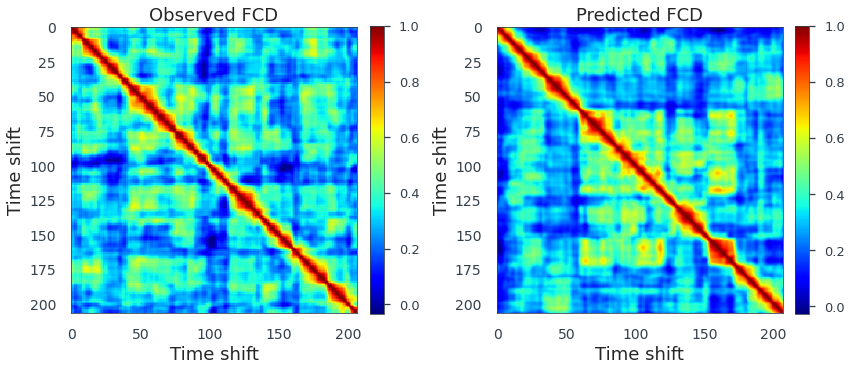

In [107]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow((FCDcorr_obs), interpolation='nearest', cmap='jet' )
plt.colorbar(fraction=0.046, pad=0.04)
plt.gca().set_title('Observed FCD', fontsize=18.0)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Time shift', fontsize=18.0)
plt.xlabel('Time shift', fontsize=18.0)


plt.subplot(122)
im = plt.imshow(FCDcorr_fit,cmap=cm.jet)
plt.colorbar(fraction=0.046, pad=0.04)
plt.gca().set_title('Predicted FCD', fontsize=18.0)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Time shift', fontsize=18.0)
plt.xlabel('Time shift', fontsize=18.0)

plt.tight_layout()
plt.savefig(os.path.join(Res_dir,"SBI_GenericHopf_SimvsPred_FCD_obs1.png"), doi=800)
plt.savefig(os.path.join(Res_dir,"SBI_GenericHopf_SimvsPred_FCD_obs1.eps"), doi=800)
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


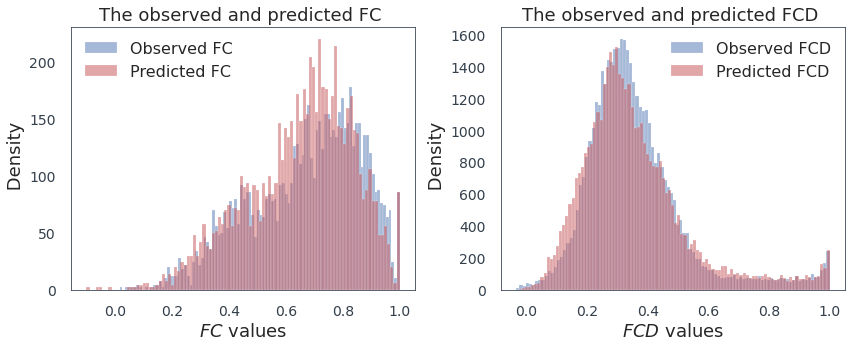

In [108]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.hist(FCcorr_obs.reshape(-1), bins=100, color='b', alpha=0.5, label='Observed FC')
plt.hist(FCcorr_fit.reshape(-1), bins=100, color='r', alpha=0.5, label='Predicted FC')
plt.gca().set_title('The observed and predicted FC ', fontsize=18.0)
plt.ylabel(' Density',fontsize=18)
plt.xlabel('$FC$ values',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)
plt.legend(fontsize=16, frameon=False)

plt.subplot(122)
plt.hist(FCDcorr_obs.reshape(-1), bins=100, color='b', alpha=0.5, label='Observed FCD')
plt.hist(FCDcorr_fit.reshape(-1), bins=100, color='r', alpha=0.5, label='Predicted FCD')
plt.gca().set_title('The observed and predicted FCD ', fontsize=18.0)
plt.ylabel(' Density',fontsize=18)
plt.xlabel('$FCD$ values',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)
plt.legend(fontsize=16, frameon=False)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_SimvsPred_HistFCFCD_obs1.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_SimvsPred_HistFCFCD_obs1.eps"), doi=800)
plt.show()

In [109]:
sum(FCcorr_obs.reshape(-1))/nn, sum(FCcorr_fit.reshape(-1))/nn

(56.38491596519117, 54.74240152379219)

In [110]:
sum(FCDcorr_obs.reshape(-1))/nn, sum(FCDcorr_fit.reshape(-1))/nn

(183.91524627854076, 182.60448907889443)

In [111]:
from scipy.stats import wasserstein_distance, energy_distance, ks_2samp
from Similaritymetrics import kl_divergence,  js_divergence
from sklearn.metrics import mutual_info_score

In [112]:
kl_divergence(FCDcorr_obs, FCDcorr_fit), kl_divergence(FCDcorr_fit, FCDcorr_obs)

(nan, nan)

In [113]:
js_divergence(FCDcorr_obs, FCDcorr_fit)

nan

In [114]:
wasserstein_distance(FCDcorr_obs.reshape(-1), FCDcorr_fit.reshape(-1))

0.0136839589506563

In [115]:
energy_distance(FCDcorr_obs.reshape(-1), FCDcorr_fit.reshape(-1))

0.026832255720658903

In [116]:
ks_2samp(FCDcorr_obs.reshape(-1), FCDcorr_fit.reshape(-1))

KstestResult(statistic=0.044995215757660634, pvalue=3.952874820116497e-38)

# Another data set

### Observed data set II (low G)

In [117]:
G_true=0.1

In [118]:
start_time = time.time()

BOLD_obs_ =GenericHopfBOLD(eta_true, omega_true, init_conditions, sigma, G_true, SC_avg_n,  dt, dt_bold, Tmax, ds)

print(" single sim (sec) takes:" , (time.time() - start_time))

 single sim (sec) takes: 3.9909729957580566


In [119]:
obs_bold_features=calculate_summary_statistics(BOLD_obs_, nn, features=['moments', 'FC_corr', 'FCD_corr'])

In [120]:
obs_bold_features.max()

9890.249110874793

In [121]:
BOLD_obs_.shape, obs_bold_features.shape

((56028,), (498,))

In [122]:
BOLD_obs=BOLD_obs_.reshape(nn, int(BOLD_obs_.shape[0]/nn))
BOLD_obs.shape

(84, 667)

In [123]:
np.save(os.path.join(Res_dir, 'Sim_BOLDobserved_TrueSCavgn_GenericHopf_G_'+str(G_true)+'.npy') , BOLD_obs)

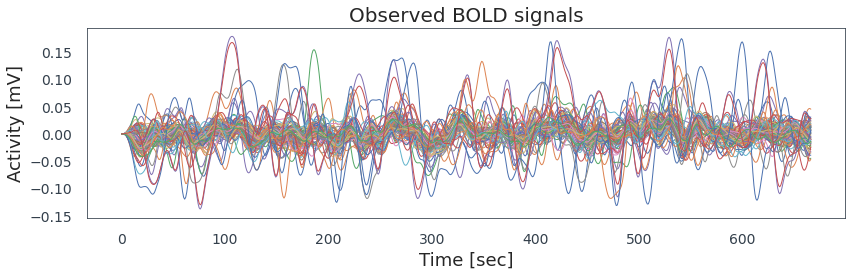

In [124]:
plt.figure(figsize=(12,4))
plt.plot(BOLD_obs.T, lw=1)
plt.title("Observed BOLD signals",fontsize=20)
plt.xlabel('Time [sec]',fontsize=18)
plt.ylabel('Activity [mV]',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_obs2.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_obs2.eps"), doi=800)
plt.show()

In [125]:
FCcorr_obs=np.corrcoef(BOLD_obs)
FCcorr_obs.shape

(84, 84)

In [126]:
FCDcorr_obs,Pcorr_obs,shift_obs=extract_FCD(BOLD_obs,wwidth,maxNwindows,olap,mode='corr')

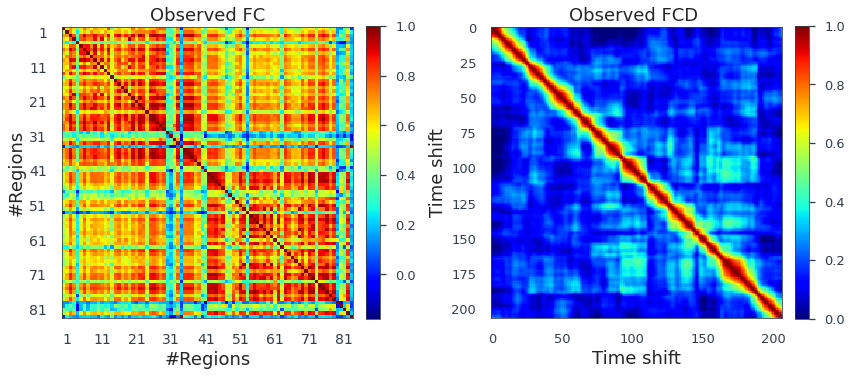

In [127]:
plt.figure(figsize=(12, 6))

plt.subplot(121)
im = plt.imshow(FCcorr,cmap=cm.jet)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.gca().set_title('Observed FC', fontsize=18.0)
plt.xticks(np.r_[1:nn+1][::10], fontsize=14)
plt.yticks(np.r_[1:nn+1][::10], fontsize=14)
plt.ylabel('#Regions', fontsize=18.0)
plt.xlabel('#Regions', fontsize=18.0)

plt.subplot(122)
plt.imshow(FCDcorr_obs, vmin=0,vmax=1, interpolation='nearest', cmap='jet' )
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Observed FCD ', fontsize=18)
plt.ylabel('Time shift', fontsize=18.0)
plt.xlabel('Time shift', fontsize=18.0)

plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_sanity_FC_FCD_obs2.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_sanity_FC_FCD_obs2.eps"), doi=800)
plt.show()

### Posterior of G for  data set II

In [128]:
labels_params = [r'$G$']

In [129]:
num_samples=2000

In [130]:
posterior = DirectPosterior(posterior_estimator, prior,) 

In [131]:
start_time = time.time()

posterior_samples = posterior.sample((num_samples,), obs_bold_features).numpy()

print(" Sampling posterior (sec) took:" , (time.time() - start_time))

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

 Sampling posterior (sec) took: 0.05620408058166504


In [132]:
np.save(os.path.join(Res_dir, 'posterior_samples_obs2.npy') , posterior_samples)

In [133]:
posterior_samples.shape, params_true.shape

((2000, 1), (1,))

In [134]:
G_posterior=posterior_samples[:,0]
np.percentile(posterior_samples, [5, 95], axis=0)

array([[0.07790266],
       [0.11044727]])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


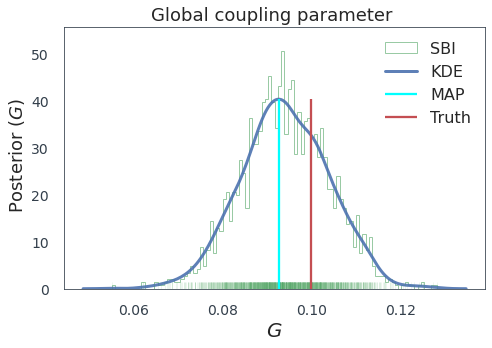

In [135]:
plt.figure(figsize=(7, 5))

#sns.distplot(G_posterior, bins=100, hist=True, kde=True, rug=True, color="b", kde_kws=dict(linewidth=3), label='SBI')
ax=sns.distplot(G_posterior, bins=100, hist=True, kde=True, rug=True, rug_kws={"alpha": 0.1, "color": "g"},
                  kde_kws={"color": "b", "alpha": 0.9, "lw": 3, "label": "KDE"},
                  hist_kws={"histtype": "step", "linewidth": 1, "alpha": 0.6, "color": "g"},
                  label='SBI')

x_ = ax.lines[0].get_xdata()
y_ = ax.lines[0].get_ydata()
ymax = max(y_)
xpos = np.argmax(y_, axis=0)
xmax = x_[xpos]
plt.vlines(x=xmax, ymin=0., ymax=y_.max(), colors='cyan', label='MAP')
plt.vlines(x=G_true, ymin=0., ymax=y_.max(), colors='r', label='Truth')

plt.title('Global coupling parameter ',fontsize=18)
plt.ylabel(' Posterior ' +r'${(G)}$', fontsize=18);  
plt.xlabel(r'${G}$', fontsize=20); 
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16, frameon=False)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_obs2.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_obs2.eps"), doi=800)
plt.show()

In [136]:
G_posterior.mean(), G_true

(0.09415387, 0.1)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


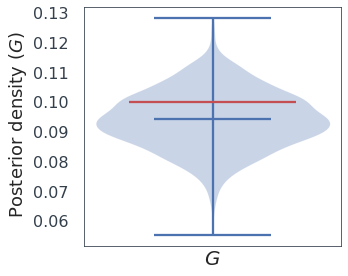

In [137]:
plt.figure(figsize=(5,4))
parts= plt.violinplot(G_posterior, widths=0.7, showmeans=True, showextrema=True);
plt.hlines(y=G_true, xmin=0.75, xmax=1.25, colors='r', label='Ground-truth')
#plt.plot(1,params_true[-1] ,'o', color='k', alpha=0.9, markersize=8)
plt.ylabel(' Posterior density ' +r'${(G)}$', fontsize=18);  
plt.xlabel(r'${G}$', fontsize=20); 
plt.xticks([])
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_InferredCoupling_obs2.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_InferredCoupling_obs2.eps"), doi=800)
plt.show()

In [138]:
np.percentile(posterior_samples, [5, 95], axis=0)

array([[0.07790266],
       [0.11044727]])

In [139]:
#np.percentile(posterior_sample, [50], axis=0)
BOLD_fit_ =GenericHopfBOLD(eta_true, omega_true, init_conditions, sigma, G_posterior.mean(), SC_avg_n,  dt, dt_bold, Tmax, ds)

In [140]:
BOLD_fit=BOLD_fit_.reshape(nn, int(BOLD_fit_.shape[0]/nn))

In [141]:
np.save(os.path.join(Res_dir, 'BOLD_obs2.npy') , BOLD_obs)
np.save(os.path.join(Res_dir, 'BOLD_fit2.npy') , BOLD_fit)

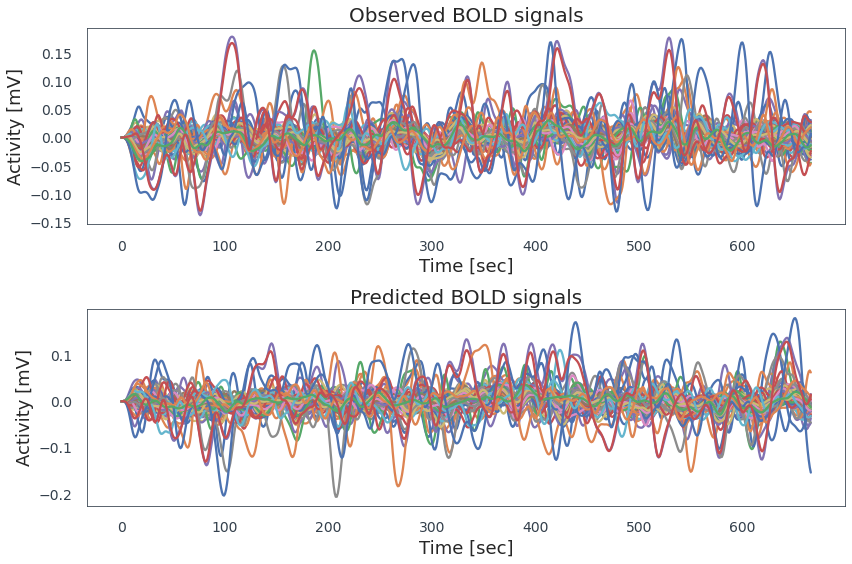

In [142]:
plt.figure(figsize=(12, 8))
plt.subplot(211);
plt.plot(BOLD_obs.T)
plt.title("Observed BOLD signals",fontsize=20)
plt.xlabel('Time [sec]',fontsize=18)
plt.ylabel('Activity [mV]',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(212)
plt.plot(BOLD_fit.T)
plt.title("Predicted BOLD signals",fontsize=20)
plt.xlabel('Time [sec]',fontsize=18)
plt.ylabel('Activity [mV]',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_FittedandobsTimeseries_obs2.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_FittedandobsTimeseries_obs2.eps"), doi=800)
plt.show()

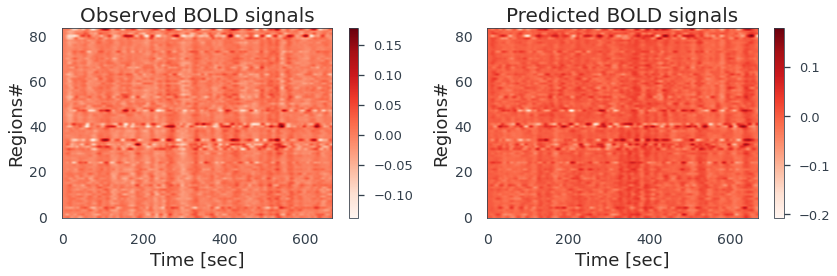

In [143]:
plt.figure(figsize=(12, 4))
plt.subplot(121);
plt.imshow(BOLD_obs, aspect='auto', interpolation='bilinear',  origin='lower', cmap='Reds')
plt.colorbar();
plt.title("Observed BOLD signals",fontsize=20)
plt.xlabel('Time [sec]',fontsize=18)
plt.ylabel("Regions#", fontsize=18);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(122)
plt.imshow(BOLD_fit, aspect='auto', interpolation='bilinear',  origin='lower', cmap='Reds')
plt.colorbar();
plt.title("Predicted BOLD signals",fontsize=20)
plt.xlabel('Time [sec]',fontsize=18)
plt.ylabel("Regions#", fontsize=18);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_FittedandobsImshow_obs2.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_FittedandobsImshow_obs2.eps"), doi=800)
plt.show()

In [144]:
FCcorr_obs=np.corrcoef(BOLD_obs)
FCcorr_fit=np.corrcoef(BOLD_fit)

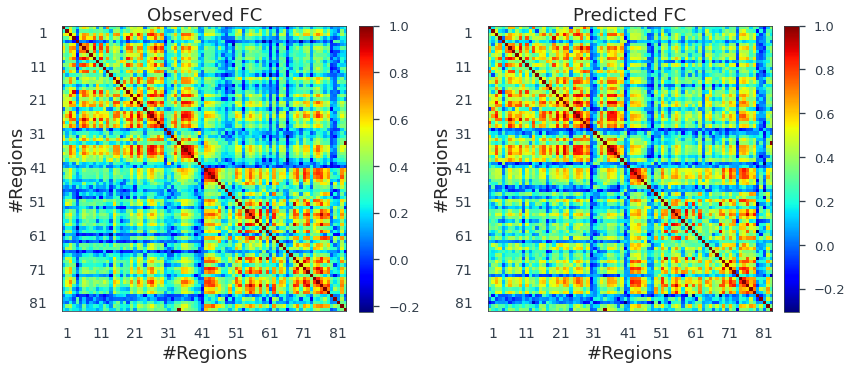

In [145]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow((FCcorr_obs), interpolation='nearest', cmap='jet' )
plt.colorbar(fraction=0.046, pad=0.04)
plt.gca().set_title('Observed FC', fontsize=18.0)
plt.xticks(np.r_[1:nn+1][::10], fontsize=14)
plt.yticks(np.r_[1:nn+1][::10], fontsize=14)
plt.ylabel('#Regions', fontsize=18.0)
plt.xlabel('#Regions', fontsize=18.0)


plt.subplot(122)
im = plt.imshow(FCcorr_fit,cmap=cm.jet)
plt.colorbar(fraction=0.046, pad=0.04)
plt.gca().set_title('Predicted FC', fontsize=18.0)
plt.xticks(np.r_[1:nn+1][::10], fontsize=14)
plt.yticks(np.r_[1:nn+1][::10], fontsize=14)
plt.ylabel('#Regions', fontsize=18.0)
plt.xlabel('#Regions', fontsize=18.0)

plt.tight_layout()
plt.savefig(os.path.join(Res_dir,"SBI_GenericHopf_SimvsPred_FC_obs2.png"), doi=800)
plt.savefig(os.path.join(Res_dir,"SBI_GenericHopf_SimvsPred_FC_obs2.eps"), doi=800)
plt.show()

In [146]:
FCDcorr_obs,Pcorr_obs,shift_obs=extract_FCD(BOLD_obs,wwidth,maxNwindows,olap,mode='corr')
FCDcorr_fit,Pcorr_fit,shift_fit=extract_FCD(BOLD_fit,wwidth,maxNwindows,olap,mode='corr')

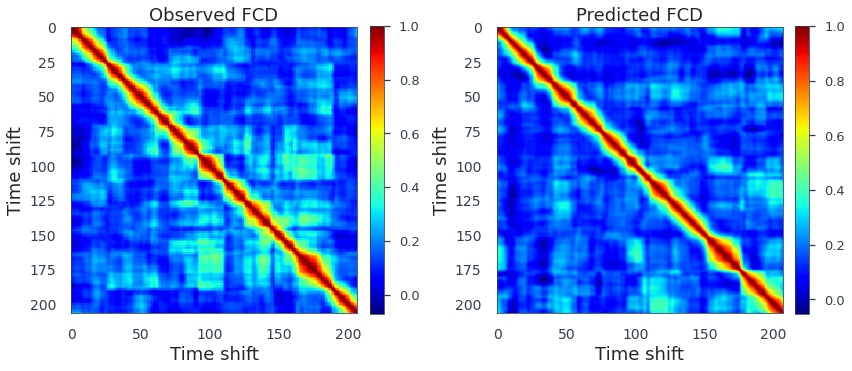

In [147]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow((FCDcorr_obs), interpolation='nearest', cmap='jet' )
plt.colorbar(fraction=0.046, pad=0.04)
plt.gca().set_title('Observed FCD', fontsize=18.0)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Time shift', fontsize=18.0)
plt.xlabel('Time shift', fontsize=18.0)


plt.subplot(122)
im = plt.imshow(FCDcorr_fit,cmap=cm.jet)
plt.colorbar(fraction=0.046, pad=0.04)
plt.gca().set_title('Predicted FCD', fontsize=18.0)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Time shift', fontsize=18.0)
plt.xlabel('Time shift', fontsize=18.0)

plt.tight_layout()
plt.savefig(os.path.join(Res_dir,"SBI_GenericHopf_SimvsPred_FCD_obs2.png"), doi=800)
plt.savefig(os.path.join(Res_dir,"SBI_GenericHopf_SimvsPred_FCD_obs2.eps"), doi=800)
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


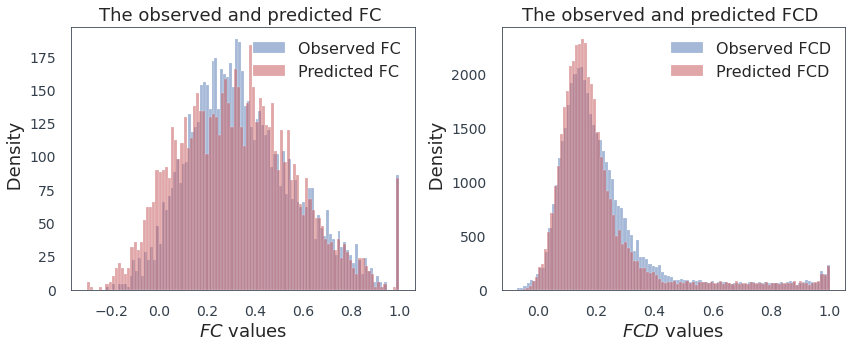

In [148]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.hist(FCcorr_obs.reshape(-1), bins=100, color='b', alpha=0.5, label='Observed FC')
plt.hist(FCcorr_fit.reshape(-1), bins=100, color='r', alpha=0.5, label='Predicted FC')
plt.gca().set_title('The observed and predicted FC ', fontsize=18.0)
plt.ylabel(' Density',fontsize=18)
plt.xlabel('$FC$ values',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)
plt.legend(fontsize=16, frameon=False)

plt.subplot(122)
plt.hist(FCDcorr_obs.reshape(-1), bins=100, color='b', alpha=0.5, label='Observed FCD')
plt.hist(FCDcorr_fit.reshape(-1), bins=100, color='r', alpha=0.5, label='Predicted FCD')
plt.gca().set_title('The observed and predicted FCD ', fontsize=18.0)
plt.ylabel(' Density',fontsize=18)
plt.xlabel('$FCD$ values',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)
plt.legend(fontsize=16, frameon=False)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_SimvsPred_HistFCFCD_obs2.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_SimvsPred_HistFCFCD_obs2.eps"), doi=800)
plt.show()

In [149]:
sum(FCcorr_obs.reshape(-1))/nn, sum(FCcorr_fit.reshape(-1))/nn

(29.350632025115747, 27.10557157396421)

In [150]:
sum(FCDcorr_obs.reshape(-1))/nn, sum(FCDcorr_fit.reshape(-1))/nn

(117.74106084374753, 109.13856517279285)

In [151]:
from scipy.stats import wasserstein_distance, energy_distance, ks_2samp
from Similaritymetrics import kl_divergence,  js_divergence
from sklearn.metrics import mutual_info_score

In [152]:
kl_divergence(FCDcorr_obs, FCDcorr_fit), kl_divergence(FCDcorr_fit, FCDcorr_obs)

(nan, nan)

In [153]:
js_divergence(FCDcorr_obs, FCDcorr_fit)

nan

In [154]:
wasserstein_distance(FCDcorr_obs.reshape(-1), FCDcorr_fit.reshape(-1))

0.017206833439871994

In [155]:
energy_distance(FCDcorr_obs.reshape(-1), FCDcorr_fit.reshape(-1))

0.041724848267502626

In [156]:
ks_2samp(FCDcorr_obs.reshape(-1), FCDcorr_fit.reshape(-1))

KstestResult(statistic=0.08644309085392887, pvalue=9.866025313340938e-140)

### Observed data set III (hight G)

In [157]:
G_true=0.5

In [158]:
start_time = time.time()

BOLD_obs_ =GenericHopfBOLD(eta_true, omega_true, init_conditions, sigma, G_true, SC_avg_n,  dt, dt_bold, Tmax, ds)

print(" single sim (sec) takes:" , (time.time() - start_time))

 single sim (sec) takes: 3.8212156295776367


In [159]:
obs_bold_features=calculate_summary_statistics(BOLD_obs_, nn, features=['moments', 'FC_corr', 'FCD_corr'])

In [160]:
obs_bold_features.max()

18934.38187882297

In [161]:
BOLD_obs_.shape, obs_bold_features.shape

((56028,), (498,))

In [162]:
BOLD_obs=BOLD_obs_.reshape(nn, int(BOLD_obs_.shape[0]/nn))
BOLD_obs.shape

(84, 667)

In [163]:
np.save(os.path.join(Res_dir, 'Sim_BOLDobserved_TrueSCavgn_GenericHopf_G_'+str(G_true)+'.npy') , BOLD_obs)

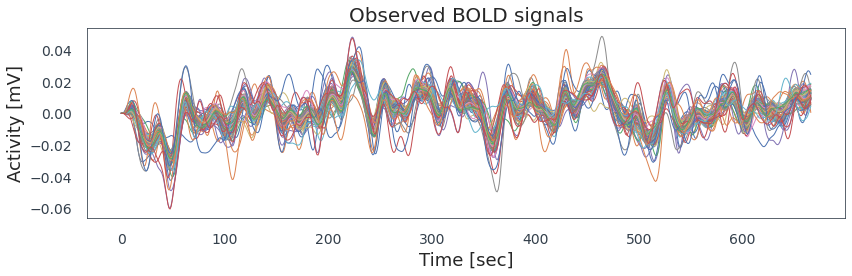

In [164]:
plt.figure(figsize=(12,4))
plt.plot(BOLD_obs.T, lw=1)
plt.title("Observed BOLD signals",fontsize=20)
plt.xlabel('Time [sec]',fontsize=18)
plt.ylabel('Activity [mV]',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_obs3.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_obs3.eps"), doi=800)
plt.show()

In [165]:
FCcorr_obs=np.corrcoef(BOLD_obs)
FCcorr_obs.shape

(84, 84)

In [166]:
FCDcorr_obs,Pcorr_obs,shift_obs=extract_FCD(BOLD_obs,wwidth,maxNwindows,olap,mode='corr')

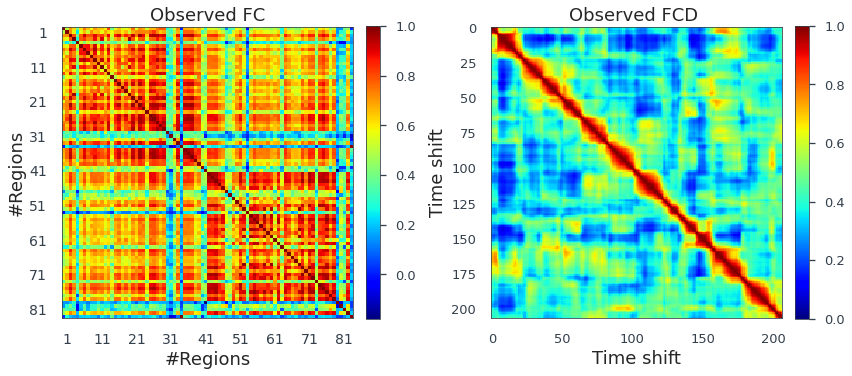

In [167]:
plt.figure(figsize=(12, 6))

plt.subplot(121)
im = plt.imshow(FCcorr,cmap=cm.jet)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.gca().set_title('Observed FC', fontsize=18.0)
plt.xticks(np.r_[1:nn+1][::10], fontsize=14)
plt.yticks(np.r_[1:nn+1][::10], fontsize=14)
plt.ylabel('#Regions', fontsize=18.0)
plt.xlabel('#Regions', fontsize=18.0)

plt.subplot(122)
plt.imshow(FCDcorr_obs, vmin=0,vmax=1, interpolation='nearest', cmap='jet' )
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Observed FCD ', fontsize=18)
plt.ylabel('Time shift', fontsize=18.0)
plt.xlabel('Time shift', fontsize=18.0)

plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_sanity_FC_FCD_obs3.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_sanity_FC_FCD_obs3.eps"), doi=800)
plt.show()

### Posterior of G for  data set III

In [168]:
labels_params = [r'$G$']

In [169]:
num_samples=2000

In [170]:
posterior = DirectPosterior(posterior_estimator, prior,) 

In [171]:
start_time = time.time()

posterior_samples = posterior.sample((num_samples,), obs_bold_features).numpy()

print(" Sampling posterior (sec) took:" , (time.time() - start_time))

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

 Sampling posterior (sec) took: 0.03368425369262695


In [172]:
np.save(os.path.join(Res_dir, 'posterior_samples_obs3.npy') , posterior_samples)

In [173]:
posterior_samples.shape, params_true.shape

((2000, 1), (1,))

In [174]:
G_posterior=posterior_samples[:,0]
np.percentile(posterior_samples, [5, 95], axis=0)

array([[0.4529213 ],
       [0.52897054]])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


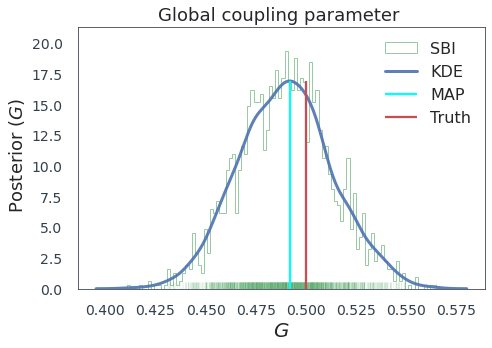

In [175]:
plt.figure(figsize=(7, 5))

#sns.distplot(G_posterior, bins=100, hist=True, kde=True, rug=True, color="b", kde_kws=dict(linewidth=3), label='SBI')
ax=sns.distplot(G_posterior, bins=100, hist=True, kde=True, rug=True, rug_kws={"alpha": 0.1, "color": "g"},
                  kde_kws={"color": "b", "alpha": 0.9, "lw": 3, "label": "KDE"},
                  hist_kws={"histtype": "step", "linewidth": 1, "alpha": 0.6, "color": "g"},
                  label='SBI')

x_ = ax.lines[0].get_xdata()
y_ = ax.lines[0].get_ydata()
ymax = max(y_)
xpos = np.argmax(y_, axis=0)
xmax = x_[xpos]
plt.vlines(x=xmax, ymin=0., ymax=y_.max(), colors='cyan', label='MAP')
plt.vlines(x=G_true, ymin=0., ymax=y_.max(), colors='r', label='Truth')

plt.title('Global coupling parameter ',fontsize=18)
plt.ylabel(' Posterior ' +r'${(G)}$', fontsize=18);  
plt.xlabel(r'${G}$', fontsize=20); 
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16, frameon=False)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_obs3.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_obs3.eps"), doi=800)
plt.show()

In [176]:
G_posterior.mean(), G_true

(0.48994097, 0.5)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


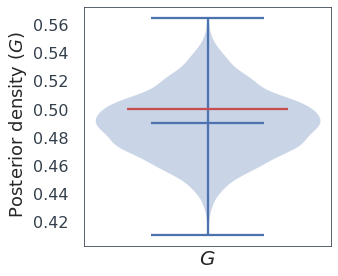

In [177]:
plt.figure(figsize=(5,4))
parts= plt.violinplot(G_posterior, widths=0.7, showmeans=True, showextrema=True);
plt.hlines(y=G_true, xmin=0.75, xmax=1.25, colors='r', label='Ground-truth')
#plt.plot(1,params_true[-1] ,'o', color='k', alpha=0.9, markersize=8)
plt.ylabel(' Posterior density ' +r'${(G)}$', fontsize=18);  
plt.xlabel(r'${G}$', fontsize=20); 
plt.xticks([])
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_InferredCoupling_obs3.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_InferredCoupling_obs3.eps"), doi=800)
plt.show()

In [178]:
np.percentile(posterior_samples, [5, 95], axis=0)

array([[0.4529213 ],
       [0.52897054]])

In [179]:
#np.percentile(posterior_sample, [50], axis=0)
BOLD_fit_ =GenericHopfBOLD(eta_true, omega_true, init_conditions, sigma, G_posterior.mean(), SC_avg_n,  dt, dt_bold, Tmax, ds)

In [180]:
BOLD_fit=BOLD_fit_.reshape(nn, int(BOLD_fit_.shape[0]/nn))

In [181]:
np.save(os.path.join(Res_dir, 'BOLD_obs3.npy') , BOLD_obs)
np.save(os.path.join(Res_dir, 'BOLD_fit3.npy') , BOLD_fit)

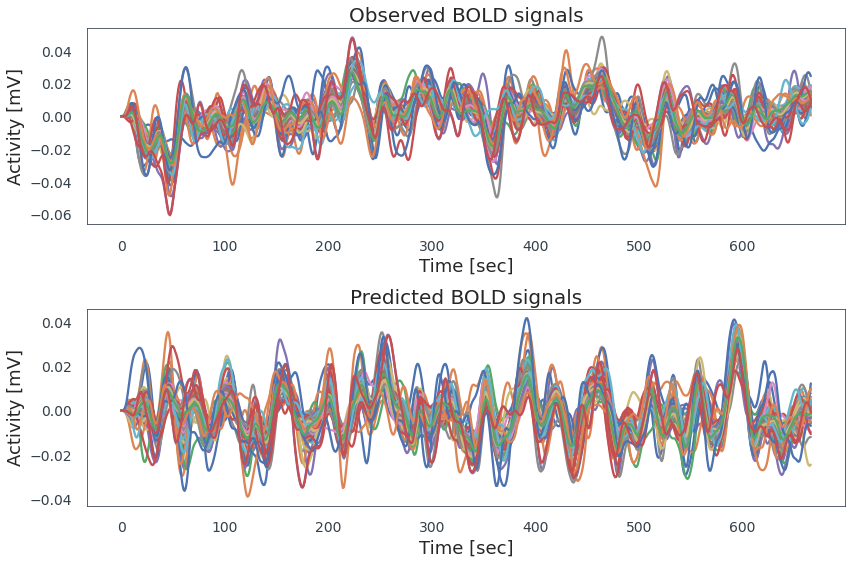

In [182]:
plt.figure(figsize=(12, 8))
plt.subplot(211);
plt.plot(BOLD_obs.T)
plt.title("Observed BOLD signals",fontsize=20)
plt.xlabel('Time [sec]',fontsize=18)
plt.ylabel('Activity [mV]',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(212)
plt.plot(BOLD_fit.T)
plt.title("Predicted BOLD signals",fontsize=20)
plt.xlabel('Time [sec]',fontsize=18)
plt.ylabel('Activity [mV]',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_FittedandobsTimeseries_obs3.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_FittedandobsTimeseries_obs3.eps"), doi=800)
plt.show()

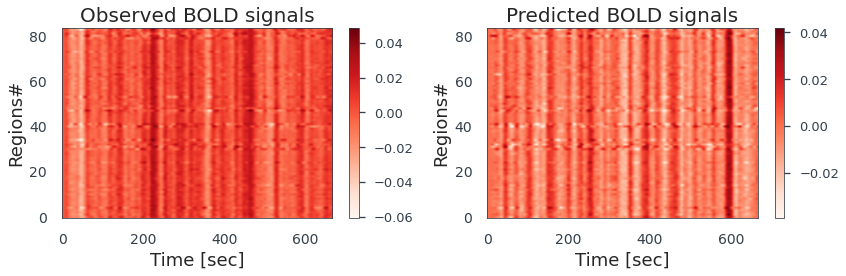

In [183]:
plt.figure(figsize=(12, 4))
plt.subplot(121);
plt.imshow(BOLD_obs, aspect='auto', interpolation='bilinear',  origin='lower', cmap='Reds')
plt.colorbar();
plt.title("Observed BOLD signals",fontsize=20)
plt.xlabel('Time [sec]',fontsize=18)
plt.ylabel("Regions#", fontsize=18);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(122)
plt.imshow(BOLD_fit, aspect='auto', interpolation='bilinear',  origin='lower', cmap='Reds')
plt.colorbar();
plt.title("Predicted BOLD signals",fontsize=20)
plt.xlabel('Time [sec]',fontsize=18)
plt.ylabel("Regions#", fontsize=18);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_FittedandobsImshow_obs3.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_FittedandobsImshow_obs3.eps"), doi=800)
plt.show()

In [184]:
FCcorr_obs=np.corrcoef(BOLD_obs)
FCcorr_fit=np.corrcoef(BOLD_fit)

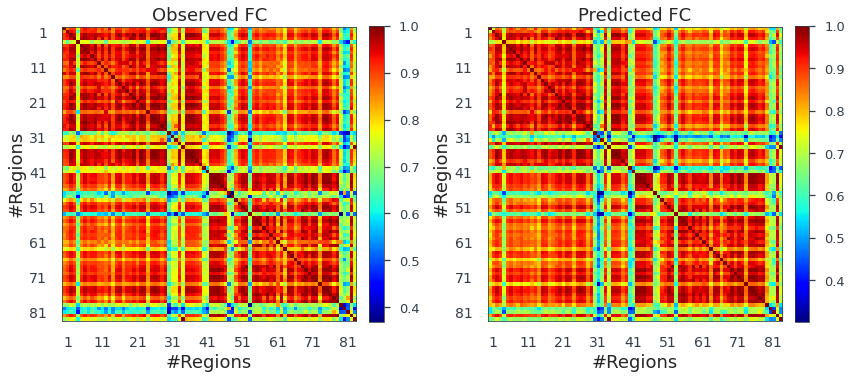

In [185]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow((FCcorr_obs), interpolation='nearest', cmap='jet' )
plt.colorbar(fraction=0.046, pad=0.04)
plt.gca().set_title('Observed FC', fontsize=18.0)
plt.xticks(np.r_[1:nn+1][::10], fontsize=14)
plt.yticks(np.r_[1:nn+1][::10], fontsize=14)
plt.ylabel('#Regions', fontsize=18.0)
plt.xlabel('#Regions', fontsize=18.0)


plt.subplot(122)
im = plt.imshow(FCcorr_fit,cmap=cm.jet)
plt.colorbar(fraction=0.046, pad=0.04)
plt.gca().set_title('Predicted FC', fontsize=18.0)
plt.xticks(np.r_[1:nn+1][::10], fontsize=14)
plt.yticks(np.r_[1:nn+1][::10], fontsize=14)
plt.ylabel('#Regions', fontsize=18.0)
plt.xlabel('#Regions', fontsize=18.0)

plt.tight_layout()
plt.savefig(os.path.join(Res_dir,"SBI_GenericHopf_SimvsPred_FC_obs3.png"), doi=800)
plt.savefig(os.path.join(Res_dir,"SBI_GenericHopf_SimvsPred_FC_obs3.eps"), doi=800)
plt.show()

In [186]:
FCDcorr_obs,Pcorr_obs,shift_obs=extract_FCD(BOLD_obs,wwidth,maxNwindows,olap,mode='corr')
FCDcorr_fit,Pcorr_fit,shift_fit=extract_FCD(BOLD_fit,wwidth,maxNwindows,olap,mode='corr')

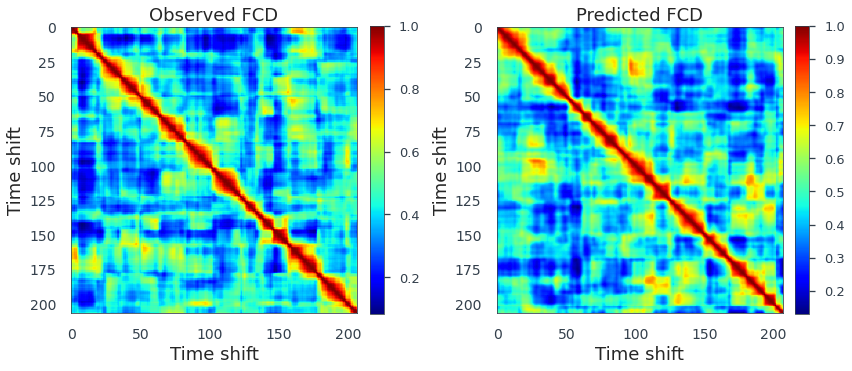

In [187]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow((FCDcorr_obs), interpolation='nearest', cmap='jet' )
plt.colorbar(fraction=0.046, pad=0.04)
plt.gca().set_title('Observed FCD', fontsize=18.0)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Time shift', fontsize=18.0)
plt.xlabel('Time shift', fontsize=18.0)


plt.subplot(122)
im = plt.imshow(FCDcorr_fit,cmap=cm.jet)
plt.colorbar(fraction=0.046, pad=0.04)
plt.gca().set_title('Predicted FCD', fontsize=18.0)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Time shift', fontsize=18.0)
plt.xlabel('Time shift', fontsize=18.0)

plt.tight_layout()
plt.savefig(os.path.join(Res_dir,"SBI_GenericHopf_SimvsPred_FCD_obs3.png"), doi=800)
plt.savefig(os.path.join(Res_dir,"SBI_GenericHopf_SimvsPred_FCD_obs3.eps"), doi=800)
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


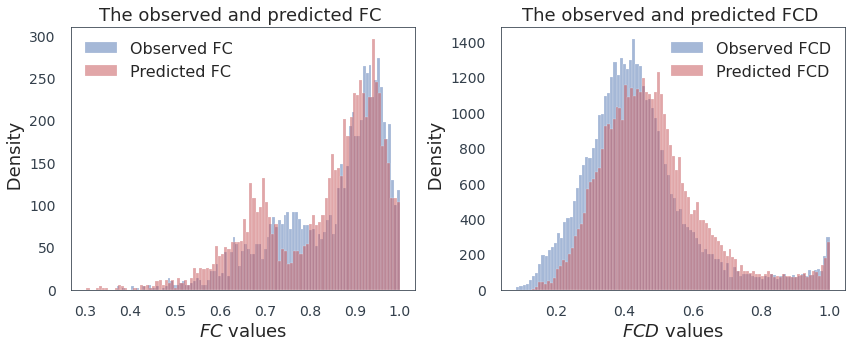

In [188]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.hist(FCcorr_obs.reshape(-1), bins=100, color='b', alpha=0.5, label='Observed FC')
plt.hist(FCcorr_fit.reshape(-1), bins=100, color='r', alpha=0.5, label='Predicted FC')
plt.gca().set_title('The observed and predicted FC ', fontsize=18.0)
plt.ylabel(' Density',fontsize=18)
plt.xlabel('$FC$ values',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)
plt.legend(fontsize=16, frameon=False)

plt.subplot(122)
plt.hist(FCDcorr_obs.reshape(-1), bins=100, color='b', alpha=0.5, label='Observed FCD')
plt.hist(FCDcorr_fit.reshape(-1), bins=100, color='r', alpha=0.5, label='Predicted FCD')
plt.gca().set_title('The observed and predicted FCD ', fontsize=18.0)
plt.ylabel(' Density',fontsize=18)
plt.xlabel('$FCD$ values',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)
plt.legend(fontsize=16, frameon=False)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_SimvsPred_HistFCFCD_obs3.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_SimvsPred_HistFCFCD_obs3.eps"), doi=800)
plt.show()

In [189]:
sum(FCcorr_obs.reshape(-1))/nn, sum(FCcorr_fit.reshape(-1))/nn

(71.33279106887254, 69.68963153849613)

In [190]:
sum(FCDcorr_obs.reshape(-1))/nn, sum(FCDcorr_fit.reshape(-1))/nn

(225.40930808122582, 246.4849994711179)

In [191]:
from scipy.stats import wasserstein_distance, energy_distance, ks_2samp
from Similaritymetrics import kl_divergence,  js_divergence
from sklearn.metrics import mutual_info_score

In [192]:
kl_divergence(FCDcorr_obs, FCDcorr_fit), kl_divergence(FCDcorr_fit, FCDcorr_obs)

(-294.0365437458554, 3453.198395832548)

In [193]:
js_divergence(FCDcorr_obs, FCDcorr_fit)

385.1915744385279

In [194]:
wasserstein_distance(FCDcorr_obs.reshape(-1), FCDcorr_fit.reshape(-1))

0.04142047945857595

In [195]:
energy_distance(FCDcorr_obs.reshape(-1), FCDcorr_fit.reshape(-1))

0.08826861162628162

In [196]:
ks_2samp(FCDcorr_obs.reshape(-1), FCDcorr_fit.reshape(-1))

KstestResult(statistic=0.14072673808023523, pvalue=0.0)

### Observed data set IIII (very hight G)

In [197]:
G_true=0.75

In [198]:
start_time = time.time()

BOLD_obs_ =GenericHopfBOLD(eta_true, omega_true, init_conditions, sigma, G_true, SC_avg_n,  dt, dt_bold, Tmax, ds)

print(" single sim (sec) takes:" , (time.time() - start_time))

 single sim (sec) takes: 3.632923126220703


In [199]:
obs_bold_features=calculate_summary_statistics(BOLD_obs_, nn, features=['moments', 'FC_corr', 'FCD_corr'])

In [200]:
obs_bold_features.max()

19205.598151178358

In [201]:
BOLD_obs_.shape, obs_bold_features.shape

((56028,), (498,))

In [202]:
BOLD_obs=BOLD_obs_.reshape(nn, int(BOLD_obs_.shape[0]/nn))
BOLD_obs.shape

(84, 667)

In [203]:
np.save(os.path.join(Res_dir, 'Sim_BOLDobserved_TrueSCavgn_GenericHopf_G_'+str(G_true)+'.npy') , BOLD_obs)

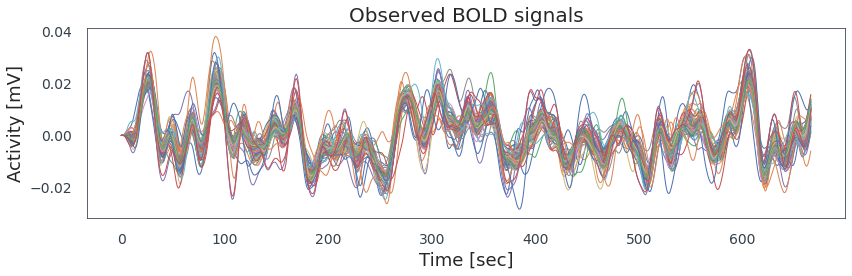

In [204]:
plt.figure(figsize=(12,4))
plt.plot(BOLD_obs.T, lw=1)
plt.title("Observed BOLD signals",fontsize=20)
plt.xlabel('Time [sec]',fontsize=18)
plt.ylabel('Activity [mV]',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_obs4.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_obs4.eps"), doi=800)
plt.show()

In [205]:
FCcorr_obs=np.corrcoef(BOLD_obs)
FCcorr_obs.shape

(84, 84)

In [206]:
FCDcorr_obs,Pcorr_obs,shift_obs=extract_FCD(BOLD_obs,wwidth,maxNwindows,olap,mode='corr')

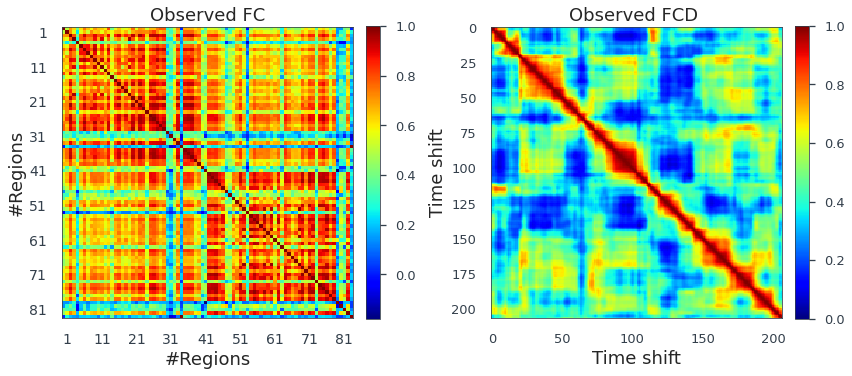

In [207]:
plt.figure(figsize=(12, 6))

plt.subplot(121)
im = plt.imshow(FCcorr,cmap=cm.jet)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.gca().set_title('Observed FC', fontsize=18.0)
plt.xticks(np.r_[1:nn+1][::10], fontsize=14)
plt.yticks(np.r_[1:nn+1][::10], fontsize=14)
plt.ylabel('#Regions', fontsize=18.0)
plt.xlabel('#Regions', fontsize=18.0)

plt.subplot(122)
plt.imshow(FCDcorr_obs, vmin=0,vmax=1, interpolation='nearest', cmap='jet' )
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Observed FCD ', fontsize=18)
plt.ylabel('Time shift', fontsize=18.0)
plt.xlabel('Time shift', fontsize=18.0)

plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_sanity_FC_FCD_obs4.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_sanity_FC_FCD_obs4.eps"), doi=800)
plt.show()

### Posterior of G for  data set III

In [208]:
labels_params = [r'$G$']

In [209]:
num_samples=2000

In [210]:
posterior = DirectPosterior(posterior_estimator, prior,) 

In [211]:
start_time = time.time()

posterior_samples = posterior.sample((num_samples,), obs_bold_features).numpy()

print(" Sampling posterior (sec) took:" , (time.time() - start_time))

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

 Sampling posterior (sec) took: 0.035051822662353516


In [212]:
np.save(os.path.join(Res_dir, 'posterior_samples_obs4.npy') , posterior_samples)

In [213]:
posterior_samples.shape, params_true.shape

((2000, 1), (1,))

In [214]:
G_posterior=posterior_samples[:,0]
np.percentile(posterior_samples, [5, 95], axis=0)

array([[0.67492348],
       [0.7742544 ]])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


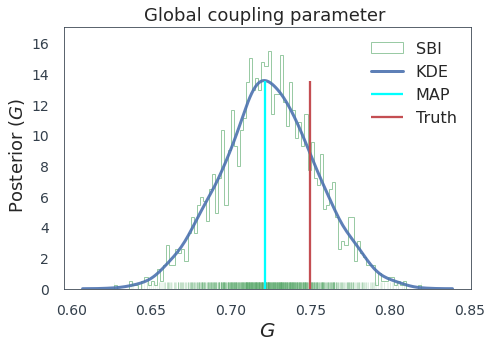

In [215]:
plt.figure(figsize=(7, 5))

#sns.distplot(G_posterior, bins=100, hist=True, kde=True, rug=True, color="b", kde_kws=dict(linewidth=3), label='SBI')
ax=sns.distplot(G_posterior, bins=100, hist=True, kde=True, rug=True, rug_kws={"alpha": 0.1, "color": "g"},
                  kde_kws={"color": "b", "alpha": 0.9, "lw": 3, "label": "KDE"},
                  hist_kws={"histtype": "step", "linewidth": 1, "alpha": 0.6, "color": "g"},
                  label='SBI')

x_ = ax.lines[0].get_xdata()
y_ = ax.lines[0].get_ydata()
ymax = max(y_)
xpos = np.argmax(y_, axis=0)
xmax = x_[xpos]
plt.vlines(x=xmax, ymin=0., ymax=y_.max(), colors='cyan', label='MAP')
plt.vlines(x=G_true, ymin=0., ymax=y_.max(), colors='r', label='Truth')

plt.title('Global coupling parameter ',fontsize=18)
plt.ylabel(' Posterior ' +r'${(G)}$', fontsize=18);  
plt.xlabel(r'${G}$', fontsize=20); 
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16, frameon=False)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_obs4.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_obs4.eps"), doi=800)
plt.show()

In [216]:
G_posterior.mean(), G_true

(0.72402745, 0.75)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


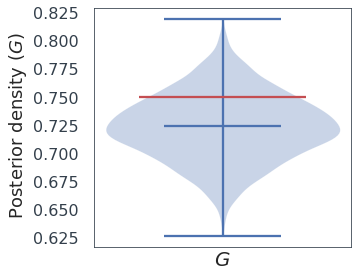

In [217]:
plt.figure(figsize=(5,4))
parts= plt.violinplot(G_posterior, widths=0.7, showmeans=True, showextrema=True);
plt.hlines(y=G_true, xmin=0.75, xmax=1.25, colors='r', label='Ground-truth')
#plt.plot(1,params_true[-1] ,'o', color='k', alpha=0.9, markersize=8)
plt.ylabel(' Posterior density ' +r'${(G)}$', fontsize=18);  
plt.xlabel(r'${G}$', fontsize=20); 
plt.xticks([])
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_InferredCoupling_obs4.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_InferredCoupling_obs4.eps"), doi=800)
plt.show()

In [218]:
np.percentile(posterior_samples, [5, 95], axis=0)

array([[0.67492348],
       [0.7742544 ]])

In [219]:
#np.percentile(posterior_sample, [50], axis=0)
BOLD_fit_ =GenericHopfBOLD(eta_true, omega_true, init_conditions, sigma, G_posterior.mean(), SC_avg_n,  dt, dt_bold, Tmax, ds)

In [220]:
BOLD_fit=BOLD_fit_.reshape(nn, int(BOLD_fit_.shape[0]/nn))

In [221]:
np.save(os.path.join(Res_dir, 'BOLD_obs4.npy') , BOLD_obs)
np.save(os.path.join(Res_dir, 'BOLD_fit4.npy') , BOLD_fit)

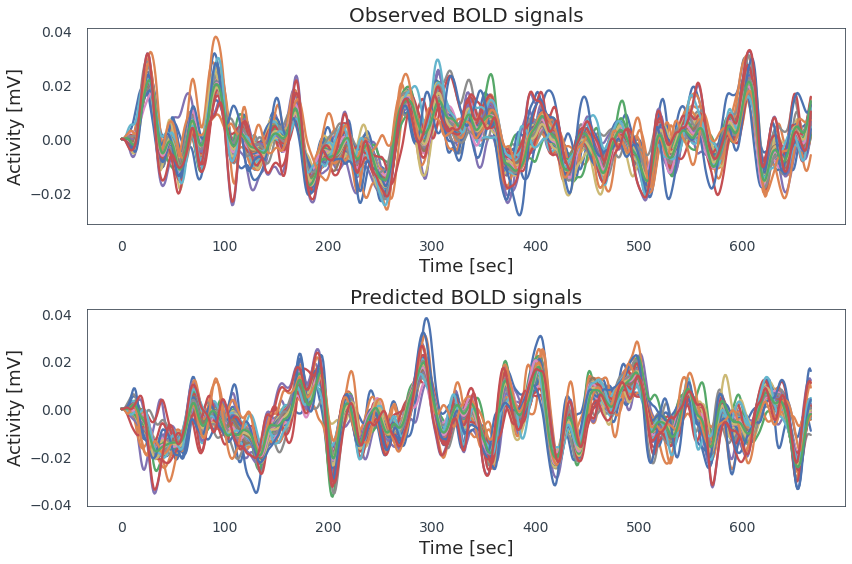

In [222]:
plt.figure(figsize=(12, 8))
plt.subplot(211);
plt.plot(BOLD_obs.T)
plt.title("Observed BOLD signals",fontsize=20)
plt.xlabel('Time [sec]',fontsize=18)
plt.ylabel('Activity [mV]',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(212)
plt.plot(BOLD_fit.T)
plt.title("Predicted BOLD signals",fontsize=20)
plt.xlabel('Time [sec]',fontsize=18)
plt.ylabel('Activity [mV]',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_FittedandobsTimeseries_obs4.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_FittedandobsTimeseries_obs4.eps"), doi=800)
plt.show()

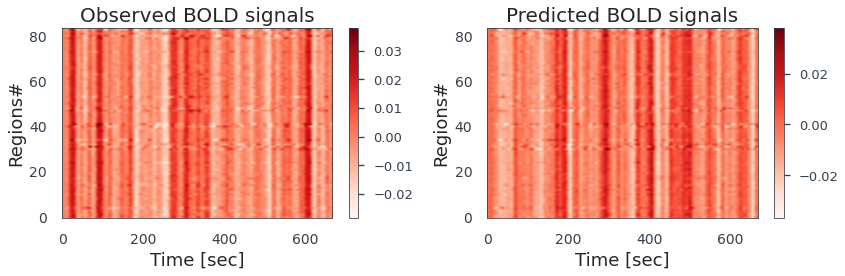

In [223]:
plt.figure(figsize=(12, 4))
plt.subplot(121);
plt.imshow(BOLD_obs, aspect='auto', interpolation='bilinear',  origin='lower', cmap='Reds')
plt.colorbar();
plt.title("Observed BOLD signals",fontsize=20)
plt.xlabel('Time [sec]',fontsize=18)
plt.ylabel("Regions#", fontsize=18);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(122)
plt.imshow(BOLD_fit, aspect='auto', interpolation='bilinear',  origin='lower', cmap='Reds')
plt.colorbar();
plt.title("Predicted BOLD signals",fontsize=20)
plt.xlabel('Time [sec]',fontsize=18)
plt.ylabel("Regions#", fontsize=18);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_FittedandobsImshow_obs4.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_FittedandobsImshow_obs4.eps"), doi=800)
plt.show()

In [224]:
FCcorr_obs=np.corrcoef(BOLD_obs)
FCcorr_fit=np.corrcoef(BOLD_fit)

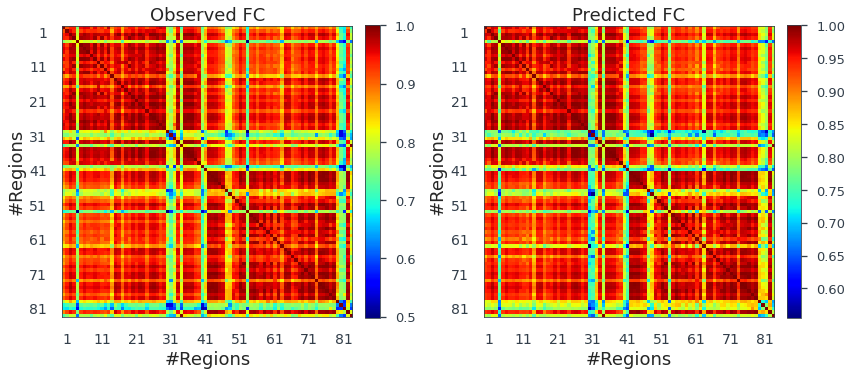

In [225]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow((FCcorr_obs), interpolation='nearest', cmap='jet' )
plt.colorbar(fraction=0.046, pad=0.04)
plt.gca().set_title('Observed FC', fontsize=18.0)
plt.xticks(np.r_[1:nn+1][::10], fontsize=14)
plt.yticks(np.r_[1:nn+1][::10], fontsize=14)
plt.ylabel('#Regions', fontsize=18.0)
plt.xlabel('#Regions', fontsize=18.0)


plt.subplot(122)
im = plt.imshow(FCcorr_fit,cmap=cm.jet)
plt.colorbar(fraction=0.046, pad=0.04)
plt.gca().set_title('Predicted FC', fontsize=18.0)
plt.xticks(np.r_[1:nn+1][::10], fontsize=14)
plt.yticks(np.r_[1:nn+1][::10], fontsize=14)
plt.ylabel('#Regions', fontsize=18.0)
plt.xlabel('#Regions', fontsize=18.0)

plt.tight_layout()
plt.savefig(os.path.join(Res_dir,"SBI_GenericHopf_SimvsPred_FC_obs4.png"), doi=800)
plt.savefig(os.path.join(Res_dir,"SBI_GenericHopf_SimvsPred_FC_obs4.eps"), doi=800)
plt.show()

In [226]:
FCDcorr_obs,Pcorr_obs,shift_obs=extract_FCD(BOLD_obs,wwidth,maxNwindows,olap,mode='corr')
FCDcorr_fit,Pcorr_fit,shift_fit=extract_FCD(BOLD_fit,wwidth,maxNwindows,olap,mode='corr')

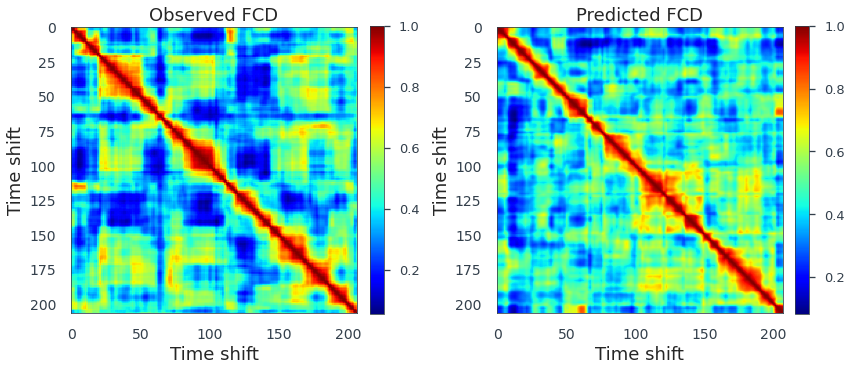

In [227]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow((FCDcorr_obs), interpolation='nearest', cmap='jet' )
plt.colorbar(fraction=0.046, pad=0.04)
plt.gca().set_title('Observed FCD', fontsize=18.0)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Time shift', fontsize=18.0)
plt.xlabel('Time shift', fontsize=18.0)


plt.subplot(122)
im = plt.imshow(FCDcorr_fit,cmap=cm.jet)
plt.colorbar(fraction=0.046, pad=0.04)
plt.gca().set_title('Predicted FCD', fontsize=18.0)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Time shift', fontsize=18.0)
plt.xlabel('Time shift', fontsize=18.0)

plt.tight_layout()
plt.savefig(os.path.join(Res_dir,"SBI_GenericHopf_SimvsPred_FCD_obs4.png"), doi=800)
plt.savefig(os.path.join(Res_dir,"SBI_GenericHopf_SimvsPred_FCD_obs4.eps"), doi=800)
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


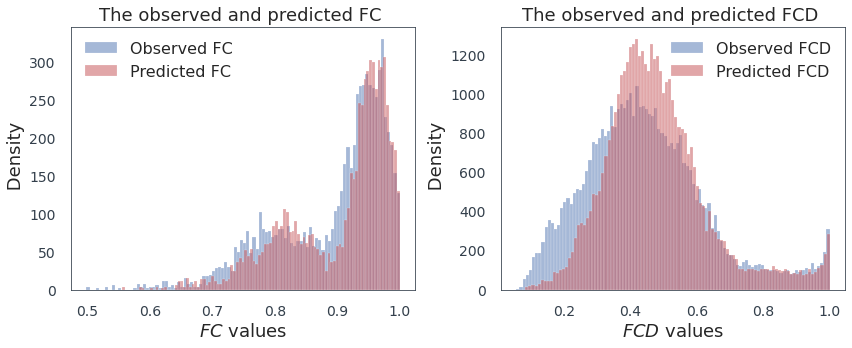

In [228]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.hist(FCcorr_obs.reshape(-1), bins=100, color='b', alpha=0.5, label='Observed FC')
plt.hist(FCcorr_fit.reshape(-1), bins=100, color='r', alpha=0.5, label='Predicted FC')
plt.gca().set_title('The observed and predicted FC ', fontsize=18.0)
plt.ylabel(' Density',fontsize=18)
plt.xlabel('$FC$ values',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)
plt.legend(fontsize=16, frameon=False)

plt.subplot(122)
plt.hist(FCDcorr_obs.reshape(-1), bins=100, color='b', alpha=0.5, label='Observed FCD')
plt.hist(FCDcorr_fit.reshape(-1), bins=100, color='r', alpha=0.5, label='Predicted FCD')
plt.gca().set_title('The observed and predicted FCD ', fontsize=18.0)
plt.ylabel(' Density',fontsize=18)
plt.xlabel('$FCD$ values',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)
plt.legend(fontsize=16, frameon=False)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_SimvsPred_HistFCFCD_obs4.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_SimvsPred_HistFCFCD_obs4.eps"), doi=800)
plt.show()

In [229]:
sum(FCcorr_obs.reshape(-1))/nn, sum(FCcorr_fit.reshape(-1))/nn

(74.95049235748176, 75.8664387556942)

In [230]:
sum(FCDcorr_obs.reshape(-1))/nn, sum(FCDcorr_fit.reshape(-1))/nn

(228.63807322831377, 245.18434811156507)

In [231]:
from scipy.stats import wasserstein_distance, energy_distance, ks_2samp
from Similaritymetrics import kl_divergence,  js_divergence
from sklearn.metrics import mutual_info_score

In [232]:
kl_divergence(FCDcorr_obs, FCDcorr_fit), kl_divergence(FCDcorr_fit, FCDcorr_obs)

(204.05014788311388, 3254.5712449671532)

In [233]:
js_divergence(FCDcorr_obs, FCDcorr_fit)

417.9629373564917

In [234]:
wasserstein_distance(FCDcorr_obs.reshape(-1), FCDcorr_fit.reshape(-1))

0.03569333638021688

In [235]:
energy_distance(FCDcorr_obs.reshape(-1), FCDcorr_fit.reshape(-1))

0.0822797846177579

In [236]:
ks_2samp(FCDcorr_obs.reshape(-1), FCDcorr_fit.reshape(-1))

KstestResult(statistic=0.13862633900441082, pvalue=0.0)